In [1]:
using HDF5, PyPlot, Glob, CSV, DataFrames, Dates, Distributions, GLM, StatsBase, MAT, NaNStatistics

In [2]:
drv = "/mnt/a82d7171-92f9-48ad-9ba4-aea036c8fec8/data_storage/collabs/maya/oddball/3isi/"
outpath = drv[1:end-5]*"output/"
motion_file = drv*"motion/motion_regression_1s_ISI.mat"
file_list = glob("*mat",drv)
fps = 4
colors=[[241, 106, 5],[82, 121, 111],[165, 0, 43],[79, 53, 155]]./255

4-element Vector{Vector{Float64}}:
 [0.9450980392156862, 0.41568627450980394, 0.0196078431372549]
 [0.3215686274509804, 0.4745098039215686, 0.43529411764705883]
 [0.6470588235294118, 0.0, 0.16862745098039217]
 [0.30980392156862746, 0.20784313725490197, 0.6078431372549019]

In [3]:
file_list

5-element Vector{String}:
 "/mnt/a82d7171-92f9-48ad-9ba4-ae" ⋯ 38 bytes ⋯ "ddball/3isi/idx_plane_3sISI.mat"
 "/mnt/a82d7171-92f9-48ad-9ba4-ae" ⋯ 47 bytes ⋯ "si/motion regression 3s ISI.mat"
 "/mnt/a82d7171-92f9-48ad-9ba4-ae" ⋯ 44 bytes ⋯ "/3isi/pipeline_output_3sISI.mat"
 "/mnt/a82d7171-92f9-48ad-9ba4-ae" ⋯ 39 bytes ⋯ "dball/3isi/raw_traces_3sISI.mat"
 "/mnt/a82d7171-92f9-48ad-9ba4-ae" ⋯ 36 bytes ⋯ "/oddball/3isi/stimuli_3sISI.mat"

In [4]:
#1 ISI 
pnum = 3
snum = 5
isi = 3*fps

12

In [5]:
pipeline_output = h5open(file_list[pnum],"r")
keys(pipeline_output)

6-element Vector{String}:
 "#refs#"
 "DF"
 "ROI_centroids"
 "fish_ncells"
 "fish_numbers"
 "idx_fish"

In [6]:
centroids = pipeline_output["ROI_centroids"][]
idx_fish = pipeline_output["idx_fish"][]
file = matopen(file_list[snum],"r")
#motion = matopen(motion_file,"r")
#motion_reg = read(motion,"motion_regressor")
keys(file)

KeySet for a Dict{String, Int64} with 4 entries. Keys:
  "framerate"
  "stimtimes"
  "stim_seq"
  "stim_freqs"

In [7]:
framerate = read(file,"framerate")
stimtimes = read(file,"stimtimes")
stimtimes = Int.(stimtimes)
stim_seq = vec(read(file,"stim_seq"))
stim_freqs = vec(read(file,"stim_freqs"))

5-element Vector{Float64}:
  531.0
 1189.0
  355.0
  794.0
 1778.0

In [8]:
DF = pipeline_output["DF"][]
IJulia.clear_output()

0

In [9]:
n_frames = length(DF[1,:])
total_rois = length(DF[:,1])
spike=[0,1.69644104899772,5.13796058542217,8.27886020152244,10.3756715204800,11.8173714529814,12.2425184714093,10.8571417354877,8.80831829681196,6.91339112244670,5.46959264663869,4.30868766622567,3.42533619066766,2.75378443486879,2.18017250852183,1.72816235135824,1.32732537295463,1.00684435500268,0.730210038304555,0.530242444093118,0.362253250339685,0.227668255288566,0.0869242416152502,0.000718266708050853,-0.0828334873368325]';
spike = vec(spike./maximum(spike))

25-element Vector{Float64}:
  0.0
  0.13856961318535252
  0.41968166904719506
  0.6762383263587934
  0.8475111999798847
  0.9652729118260452
  1.0
  0.8868389098895824
  0.71948580820054
  0.5647033442172837
  0.446770218024352
  0.35194455097519445
  0.27979015908099764
  0.22493610618598375
  0.17808202728983583
  0.14116068972198187
  0.10841930735529735
  0.08224160391132143
  0.05964541037939694
  0.043311549443966584
  0.02958976547069764
  0.0185965212811607
  0.007100192809040859
  5.866984883284147e-5
 -0.006766049610648217

### Detect block edges and stimulus times

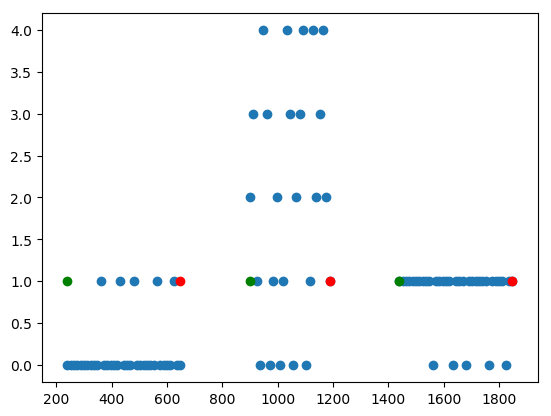

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/stednitz/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


10-element Vector{Int64}:
  288
  504
  528
  552
  576
 1464
 1488
 1512
 1536
 1752

In [10]:
scatter(stimtimes,stim_seq)

block_edges = Array{Int64}(undef,3,2)
b_ctr = 1
block_edges[1,1] = stimtimes[1]
block_edges[3,2] = stimtimes[end]
flag = 0
for s = 2:length(stimtimes)-1
    isi_now = stimtimes[s+1]-stimtimes[s]
    if isi_now > isi
        block_edges[b_ctr,2] = stimtimes[s]
        b_ctr+=1
        flag = 1
    end
    if flag == 1 && isi_now == isi
        block_edges[b_ctr,1] = stimtimes[s]
        flag = 0
    end
end

for b = 1:3
    scatter(block_edges[b,1],1,color="green")
    scatter(block_edges[b,2],1,color="red")
end

oddball_times = []
oddball_1st = []
oddball_2nd = []

for i = 1:35
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(oddball_times,stimtimes[i])
        append!(oddball_1st,stimtimes[i])

    end
end

for i = length(stimtimes)-35:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 0
        append!(oddball_times,stimtimes[i])
        append!(oddball_2nd,stimtimes[i])

    end
end

f1_times = []
f2_times = []
for i = 1:length(stimtimes)
    curr_stim = stim_seq[i]
    if curr_stim == 1
        append!(f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(f1_times,stimtimes[i])
    end
end

ms_f1_times = []
ms_f2_times = []

for i = findall((stimtimes .>= block_edges[2,1]) .&& (stimtimes .<= block_edges[2,2]))
    curr_stim = stim_seq[i[2]]
    if curr_stim == 1
        append!(ms_f2_times,stimtimes[i])
    elseif curr_stim == 0
        append!(ms_f1_times,stimtimes[i])
    end
end

rng1 = Int(block_edges[1,1]):isi*2:Int(block_edges[1,2])
rng2 = Int(block_edges[3,1]):isi*2:Int(block_edges[3,2])

randtimes = vcat(sort(sample(rng1,5,replace=false)),sort(sample(rng2,5,replace=false)))

r1 = collect(rng1)
rn2 = collect(rng2)
filter!(r1->r1∉oddball_1st,r1)
filter!(rn2->rn2∉oddball_2nd,rn2)

#offset_1 = sort(rand(r1,5))
offset_1 = sort(sample(r1, 5, replace=false))
offset_2 = sort(sample(rn2,5,replace=false))
offset_all = vcat(offset_1,offset_2)


In [11]:
offset_1

function space_segments(times)
    for t = 1:length(times)-1
        dist = times[t+1] - times[t]
        if dist == isi
            times[t+1] += 4
        end
    end
    return times
end

test = space_segments(offset_1)


5-element Vector{Int64}:
 264
 288
 312
 408
 552

### Compute regressors

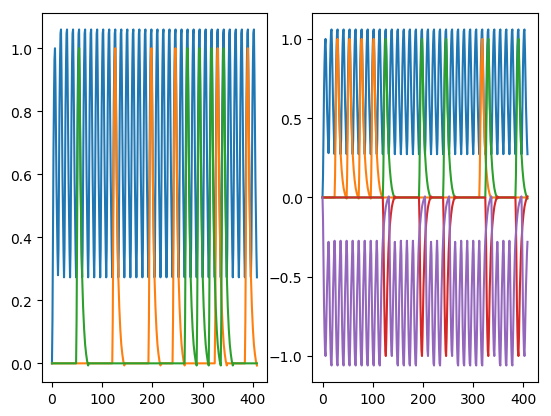

10-element Vector{String}:
 "auditory"
 "oddball"
 "oddball_offset"
 "random"
 "freq1"
 "freq2"
 "ob_1st"
 "ob_2nd"
 "ob_1st_offset"
 "ob_2nd_offset"

In [14]:
function compute_calcium(times)
    reg = zeros((n_frames))
    for stim in times
        nd = stim + length(spike)
        off = 0
        if length(reg) < stim+length(spike) 
            off = nd - length(reg)
            nd = length(reg)
        end
        reg[stim:nd-1] .+= spike[1:end-off]
    end
    return reg
end

auditory_reg = compute_calcium(stimtimes)
oddball_reg = compute_calcium(oddball_times)
oddball_offset_reg = compute_calcium(offset_all)
random_reg = compute_calcium(randtimes)

f1_reg = compute_calcium(f1_times)
f2_reg = compute_calcium(f2_times)

ms_f1_reg = compute_calcium(ms_f1_times)
ms_f2_reg = compute_calcium(ms_f2_times)

ob1_reg = compute_calcium(oddball_1st)
ob2_reg = compute_calcium(oddball_2nd)

ob1_offset_reg = compute_calcium(offset_1)
ob2_offset_reg = compute_calcium(offset_2)

subplot(121)
rng = block_edges[1,1]:block_edges[1,2]
plot(auditory_reg[rng])
plot(oddball_reg[rng])
plot(oddball_offset_reg[rng])

subplot(122)
rng = block_edges[3,1]:block_edges[3,2]
plot(auditory_reg[rng])
plot(oddball_offset_reg[rng])
plot(oddball_reg[rng])
plot(.-f1_reg[rng])
plot(.-f2_reg[rng])

exp_regs = [auditory_reg,oddball_reg,oddball_offset_reg,random_reg,f1_reg,f2_reg,ob1_reg,ob2_reg,ob1_offset_reg,ob2_offset_reg]#,motion_reg]
reg_titles = ["auditory","oddball","oddball_offset","random","freq1","freq2","ob_1st","ob_2nd","ob_1st_offset","ob_2nd_offset"]#,"motion"]

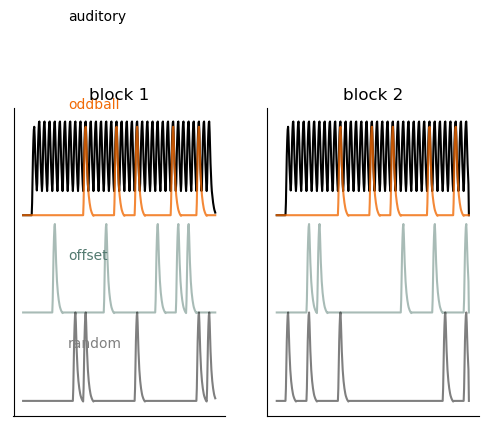

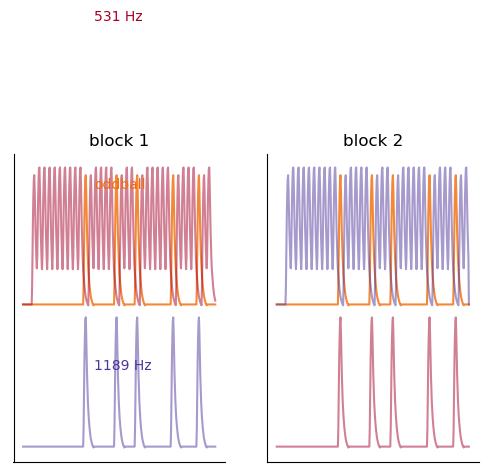

Any[]

In [16]:
figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 105
text(xpos,2.2,"auditory",color="black")
text(xpos,1.2,"oddball",color=colors[1])
text(xpos,-0.5,"offset",color=colors[2])
text(xpos,-1.5,"random",color="gray")

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(oddball_offset_reg[rng].-1.1,color=colors[2],alpha=0.5)
plot(random_reg[rng].-2.1,color="black",alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

figure(figsize=(6,4))

ax = subplot(121); title("block 1")
rng = block_edges[1,1]-fps*5:block_edges[1,2]+fps*5
#plot(auditory_reg[rng],color="black")
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f1_reg[rng],color=colors[3],alpha=0.5)
plot(f2_reg[rng].-1.1,color=colors[4],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])
xpos = 165
text(xpos,2.2,"531 Hz",color=colors[3])
text(xpos,0.9,"oddball",color=colors[1])
text(xpos,-0.5,"1189 Hz",color=colors[4])
#text(xpos,-1.5,"random",color=colors[4])

ax = subplot(122); title("block 2")
rng = block_edges[3,1]-fps*5:n_frames
plot(oddball_reg[rng],color=colors[1],alpha=0.8)
plot(f2_reg[rng],color=colors[4],alpha=0.5)
plot(f1_reg[rng].-1.1,color=colors[3],alpha=0.5)
ax.spines["top"].set_visible(false)
ax.spines["right"].set_visible(false)
ax.set_yticks([]); ax.set_xticks([])

## Regression

In [15]:
#for i =1:total_rois
coeffs = Array{Float32}(undef,length(exp_regs),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs),total_rois); fill!(r2s,NaN)
pvals = Array{Float32}(undef,length(exp_regs),total_rois); fill!(pvals,NaN)

t = now()
print("starting $t ...")
for i = 1:total_rois
    reg_ctr = 1
    yr = DF[i,:]
    for r = 1:length(exp_regs)
        t = now()
        xr = exp_regs[r]
        df = DataFrame([yr,xr],["y","x"])
        ols = lm(@formula(y ~ x),df)
        r2s[reg_ctr,i] = r2(ols)
        coeffs[reg_ctr,i] = coef(ols)[2]
        pvals[reg_ctr,i] = coeftable(ols).cols[4][2]
        reg_ctr +=1
    end
end
t = now()
print("...complete $t")

starting 2024-02-22T10:16:17.049 ......complete 2024-02-22T10:18:50.943

In [16]:
short_id = file_list[pnum][length(drv)+17:end-4]
outfile = outpath*short_id*".h5"
if isfile(outfile) rm(outfile) end
of = h5open(outfile,"w")

for r=1:length(exp_regs)
    create_group(of,reg_titles[r])
    of[reg_titles[r]]["reg"] = exp_regs[r]
    of[reg_titles[r]]["r2"] = r2s[r,:]
    of[reg_titles[r]]["coef"] = coeffs[r,:]
    of[reg_titles[r]]["pval"] = pvals[r,:]

end

close(of)

### Read in the data if you already have it

In [15]:
short_id = file_list[pnum][length(drv)+17:end-4]
outfile = outpath*short_id*".h5"

of = h5open(outfile,"r")
coeffs = Array{Float32}(undef,length(exp_regs),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs),total_rois); fill!(r2s,NaN)
pvals = Array{Float32}(undef,length(exp_regs),total_rois); fill!(pvals,NaN)
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

for r=1:length(exp_regs)
    temp = of[reg_titles[r]]["r2"][]
    r2s[r,:] .= of[reg_titles[r]]["r2"][]
    coeffs[r,:] .= of[reg_titles[r]]["coef"][]
    pvals[r,:] .= of[reg_titles[r]]["pval"][]
    push!(sig_rois, of[reg_titles[r]]["sig_rois"][])
    push!(nonsig_rois, of[reg_titles[r]]["nonsig_rois"][])
end
close(of)

### Detect significant ROIs (p < .001/total ROIs && R^2 > 99th percentile)

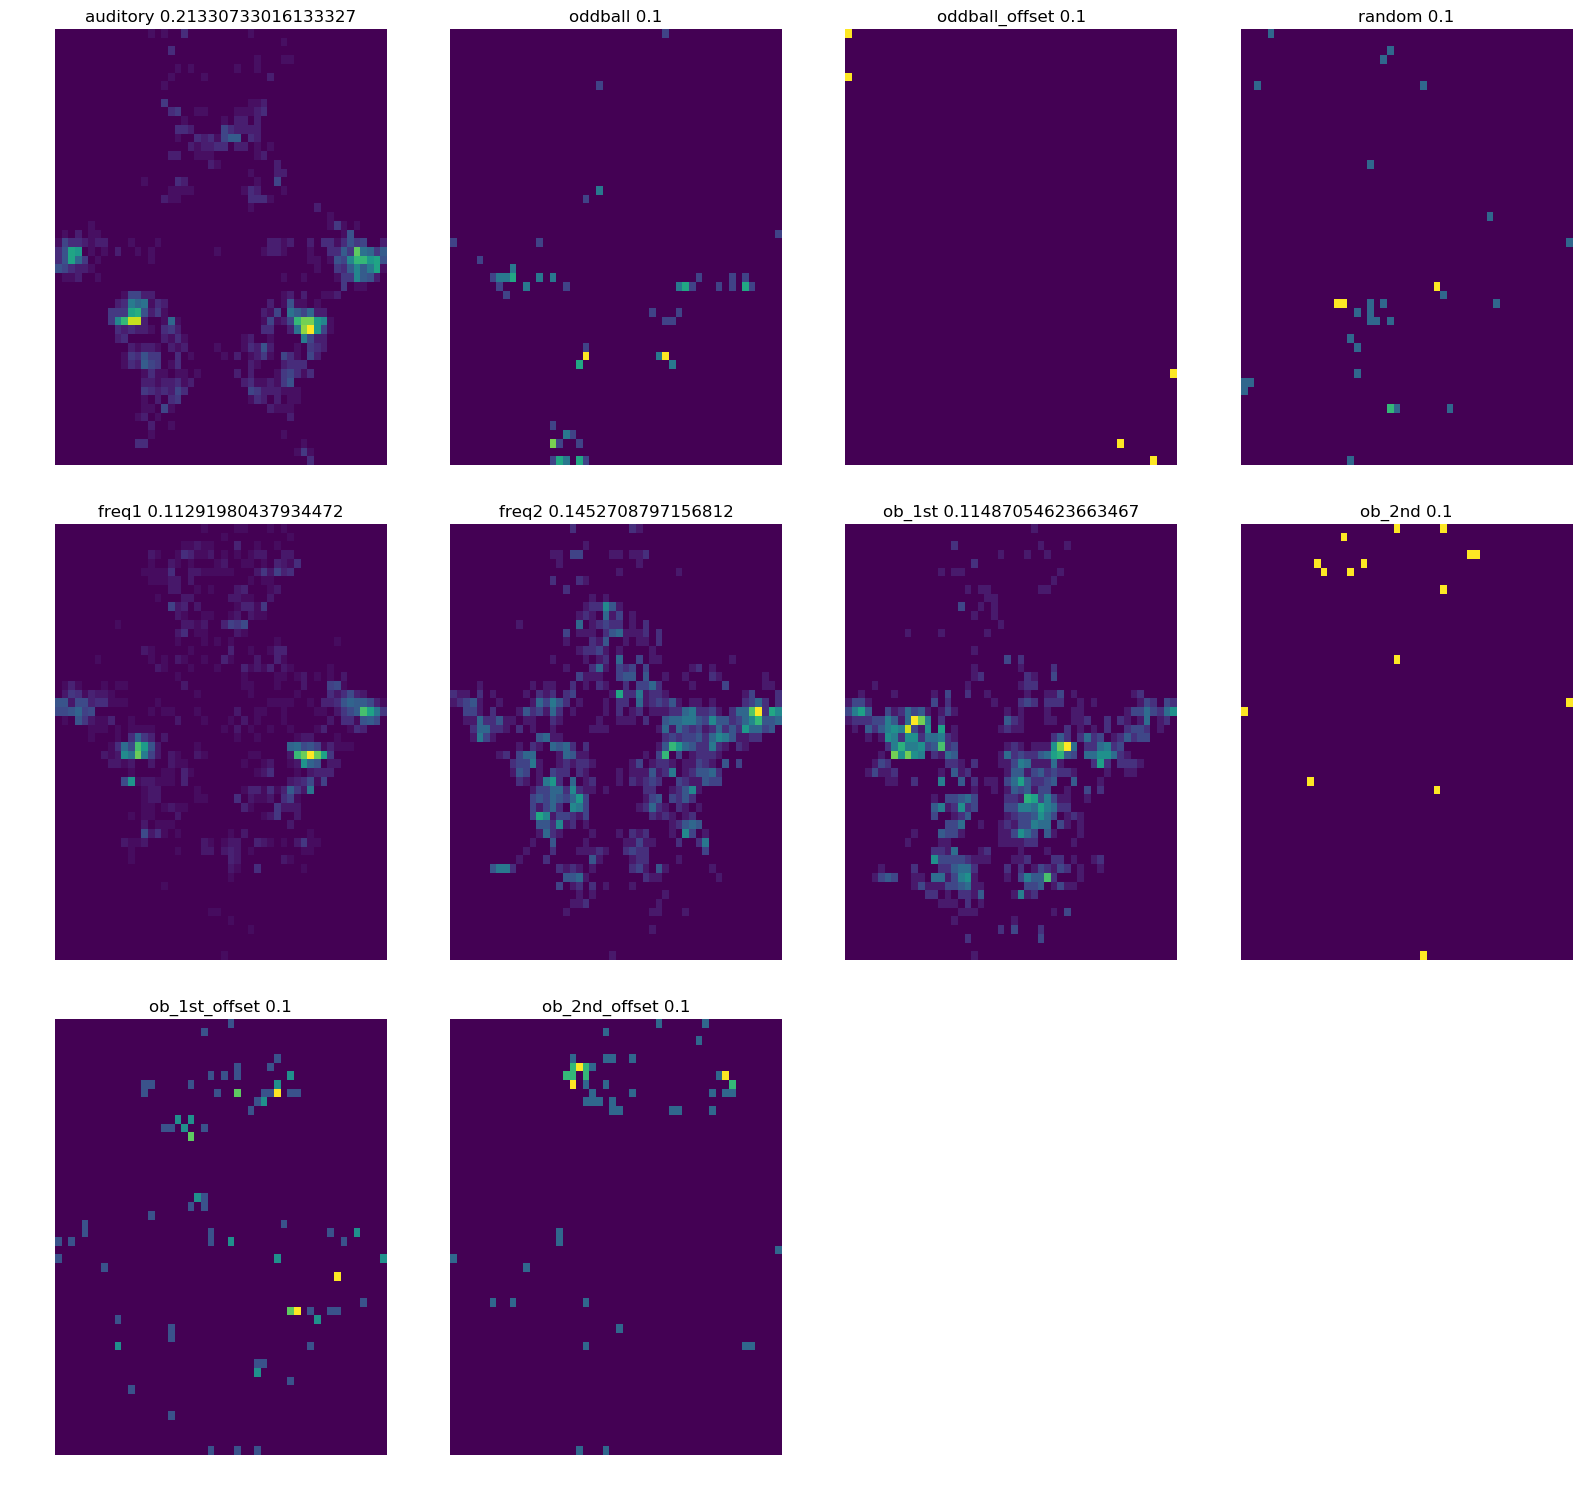

In [23]:
sig_rois = Array{Int64}[]
nonsig_rois = Array{Int64}[]

rows,cols=3,4
figure(figsize=(cols*4,rows*5)); 
perc_cutoff = 99
alpha_cutoff = 0.001/total_rois
minimum_r2 = 0.1
for r=1:length(exp_regs)
    pvals_clean = pvals[r,:]
    sig_roi_pval = findall(pvals_clean .< alpha_cutoff); #idx_rest_pval = findall(pvals_clean .>= alpha_cutoff)
    
    r2s_clean = replace(r2s[r,:],NaN=>0)
    perc_99 = percentile(r2s_clean,perc_cutoff)
    if perc_99 < minimum_r2 perc_99 = minimum_r2 end
    
    sig_roi_r2 = findall(r2s_clean .> perc_99); #idx_rest_r2 = findall(r2s_clean .<= percentile(r2s_clean,perc_99))
    
    sig_roi = intersect(sig_roi_pval,sig_roi_r2)
    nonsig_roi = collect(1:total_rois)
    deleteat!(nonsig_roi,sig_roi[1])

    push!(sig_rois,sig_roi)
    push!(nonsig_rois,nonsig_roi)
    subplot(rows,cols,r)
    title(reg_titles[r]*" $perc_99")
    plt.hist2d(centroids[sig_roi,2],centroids[sig_roi,1],bins=50); axis("off");
end

tight_layout()

### Exclude overlapping ROIs

In [24]:
no_overlap_sig = Array{Int64}[]
no_overlap_nonsig = Array{Int64}[]

exclude = copy(unique(vcat(sig_rois[1,:][1],sig_rois[3,:][1],sig_rois[9,:][1],sig_rois[10,:][1],sig_rois[5,:][1],sig_rois[6,:][1])))

for i in [7,8]
    sr = copy(sig_rois[i,:][1])
    del_idx = []
    for s = 1:length(sr)
        if (sr[s] in exclude) == true
            append!(del_idx,s)
        end
    end
    
    deleteat!(sr,del_idx)
    nonsig_roi = collect(1:total_rois)
    deleteat!(nonsig_roi,sr)
    
    push!(no_overlap_sig,sr)
    push!(no_overlap_nonsig,nonsig_roi)
    
    push!(sig_rois,sr)
    push!(nonsig_rois,sr)
end

In [1]:
of = h5open(outfile,"r+")
of["centroids"] = centroids
of["idx_fish"] = idx_fish
for r=1:length(exp_regs)    
    of[reg_titles[r]]["sig_rois"] = sig_rois[r,:][1]
    of[reg_titles[r]]["nonsig_rois"] = nonsig_rois[r,:][1]
end
close(of)

LoadError: UndefVarError: h5open not defined

In [22]:
using PyCall
@pyimport matplotlib.colors as matcolors

bwr_black = matcolors.LinearSegmentedColormap.from_list("bwr_black", (
                 (0.000, (0.298, 0.443, 1.000)),
                 (0.250, (0.000, 0.145, 0.702)),
                 (0.500, (0.000, 0.000, 0.000)),
                 (0.750, (0.780, 0.012, 0.051)),
                 (1.000, (0.988, 0.290, 0.325))))

In [23]:
typeof(bwr_black)

ColorMap

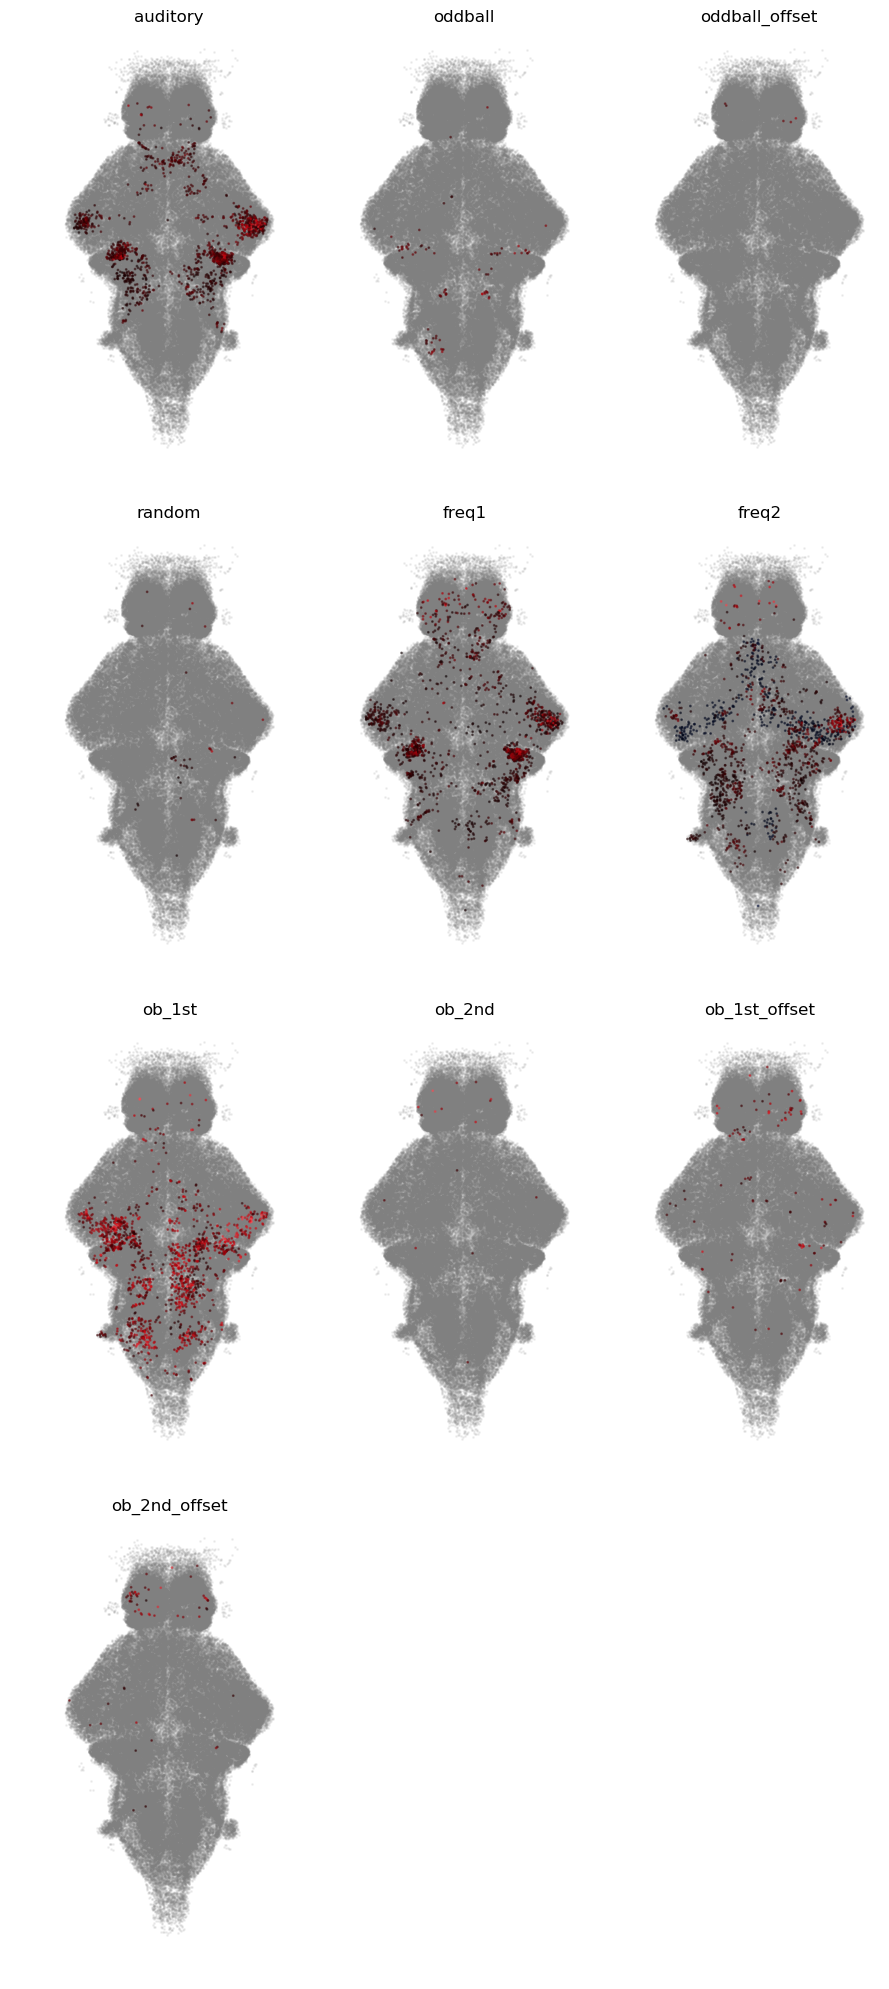

In [24]:
rows,cols=4,3
figure(figsize=(cols*3,rows*5)); 

r=1
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    subplot(rows,cols,r); axis("off")
    title(reg_titles[r])
    co = (coeffs[r,sr])
    scatter(centroids[nr,2],centroids[nr,1],color="gray",s=1,alpha=0.1)
    scatter(centroids[sr,2],centroids[sr,1],c=co,cmap=bwr_black,s=1,alpha=0.5,vmin=-0.3,vmax=0.3)
end

tight_layout()

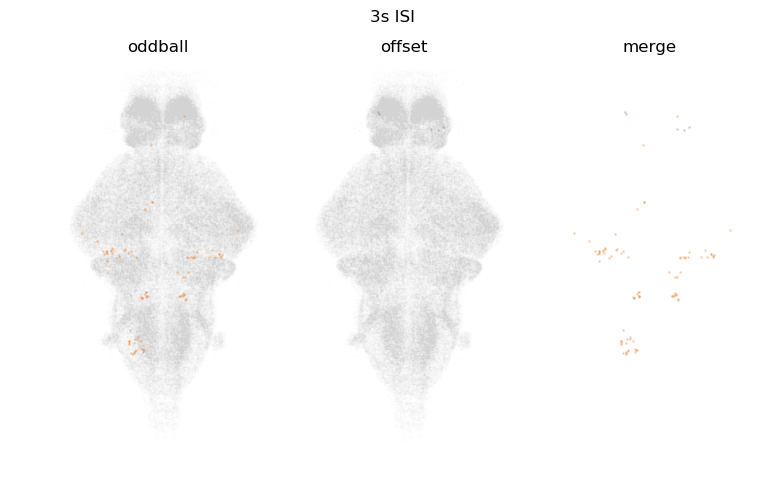

In [19]:
figure(figsize=(9,5)); 
suptitle("3s ISI")
a = 0.2

ymn,ymx=200,1300
xmn,xmx=0,600
titles = ["oddball","offset","merge"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]
nr2 = nonsig_rois[3,:][1]
sr2 = sig_rois[3,:][1]

nsa = 0.002

ax1 = subplot(131); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ax2 = subplot(132); 
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=1,alpha=a)

ax3 = subplot(133); 
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[2],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

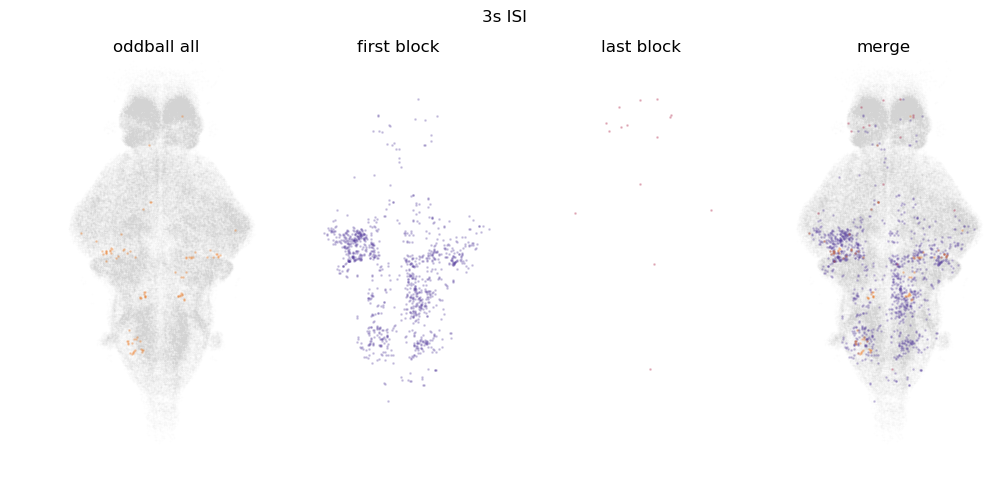

In [25]:
figure(figsize=(12,5)); 
suptitle("3s ISI")
a = 0.2

titles = ["oddball all","first block","last block","merge"]

sr1 = sig_rois[2,:][1]
nr1 = nonsig_rois[2,:][1]
nr2 = nonsig_rois[11,:][1]
sr2 = sig_rois[11,:][1]
nr3 = nonsig_rois[12,:][1]
sr3 = sig_rois[12,:][1]

ax1 = subplot(141); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ax2 = subplot(142);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

ax3 = subplot(143);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)

ax4 = subplot(144);
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

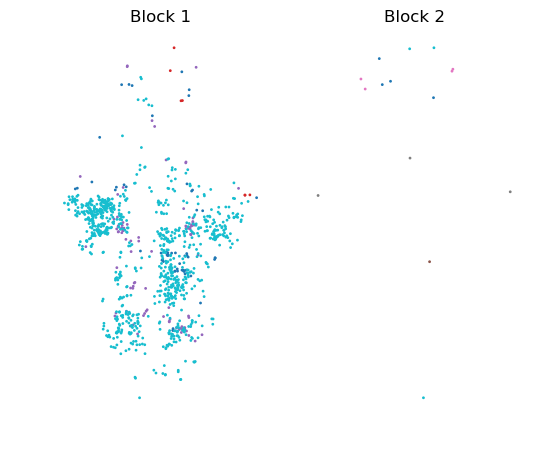

PyObject <matplotlib.collections.PathCollection object at 0x7fc3bbafa2b0>

In [26]:
figure(figsize=(6,5))

sr1 = sig_rois[11,:][1]
sr2 = sig_rois[12,:][1]

subplot(121); axis("off"); title("Block 1")
scatter(centroids[sr1,2],centroids[sr1,1],c=idx_fish[sr1]/100,s=1,cmap="tab10")

subplot(122); axis("off"); title("Block 2")
scatter(centroids[sr2,2],centroids[sr2,1],c=idx_fish[sr2]/100,s=1,cmap="tab10")

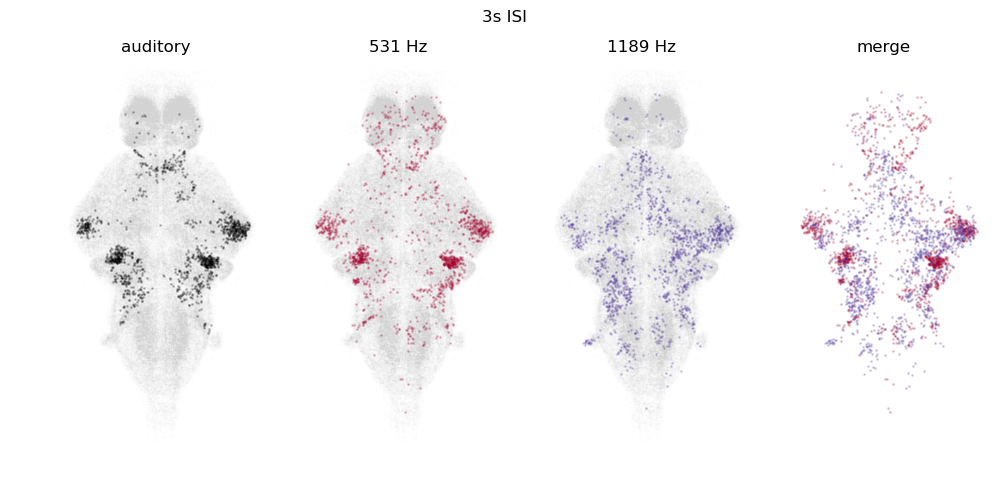

In [37]:
figure(figsize=(12,5)); 
suptitle("3s ISI")
a = 0.2

titles = ["auditory","531 Hz","1189 Hz","merge"]

sr1 = sig_rois[1,:][1]
nr1 = nonsig_rois[1,:][1]
nr2 = nonsig_rois[5,:][1]
sr2 = sig_rois[5,:][1]
nr3 = nonsig_rois[6,:][1]
sr3 = sig_rois[6,:][1]



ax1 = subplot(141); 
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color="black",s=1,alpha=a)

ax2 = subplot(142);
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)

ax3 = subplot(143);
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)

ax4 = subplot(144);
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[3],s=1,alpha=a)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[4],s=1,alpha=a)
#scatter(centroids[sr1,2],centroids[sr1,1],color=colors[1],s=1,alpha=a)

ctr = 1
for ax in [ax1,ax2,ax3,ax4]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ax.set_title(titles[ctr])
    ctr+=1
end

In [24]:
fish_list = unique(idx_fish)
n_fish = length(fish_list)
reset_idx = collect(1:n_fish)

reset_idx_fish = copy(idx_fish)
for i in 1:length(idx_fish)
    loc = findall(idx_fish[i] .== fish_list)[1]
    reset_idx_fish[i] = Int.(reset_idx[loc])
end

In [30]:
ctr = 0
cm = PyPlot.cm.get_cmap("nipy_spectral")

subplot(121)

n_fish = size(motion_reg)[1]
for i = 1:n_fish
    plot(motion_reg[i][:].+ctr,color=cm(i/n_fish),linewidth=1)
    ctr+=0.05
end

ctr = 0

for s in stimtimes
   axvline(s,0,1,color="black",linewidth=1,alpha=0.1) 
end

for s in oddball_times
   axvline(s,0,1,color="red",linewidth=1,alpha=0.5) 
end

xlim(block_edges[1,1]-fps*5,block_edges[1,2]+fps*5)
xlim(block_edges[3,1]-fps*5,block_edges[3,2]+fps*5)
#xlim(block_edges[2,1]-fps*5,block_edges[2,2]+fps*5)

#figure(figsize=(6,5))

subplot(122); axis("off"); title("oddball")
scatter(centroids[sr1,2],centroids[sr1,1],c=reset_idx_fish[sr1]/n_fish,s=1,cmap=cm)

LoadError: UndefVarError: motion_reg not defined

In [663]:
reg_titles

11-element Vector{String}:
 "auditory"
 "oddball"
 "oddball_offset"
 "random"
 "freq1"
 "freq2"
 "ob_1st"
 "ob_2nd"
 "ob_1st_offset"
 "ob_2nd_offset"
 "motion"

In [20]:
#figure(figsize=(10,10)); 
#rows,cols=4,3

figure(figsize=(6,3))
ctr = 1
ax1 = subplot(121)
ax2 = subplot(122)

titles = ["oddball","offset"]
for r in [2,3]
    subplot(1,2,ctr)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    avg = vec(mean(DF[sr,:],dims=1))
    avg_n = vec(mean(DF[nr,:],dims=1))
    plot(avg_n,color=colors[ctr],linewidth=1,alpha=0.5)
    plot(avg,color=colors[ctr],linewidth=1)
    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
    ax.set_ylim(0,0.2)
    text(5,0.19,titles[ctr],color=colors[ctr])
    ctr+=1 
end

ctr = 1
for ax in [ax1,ax2]
    ax.set_ylim(0,0.2)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ctr+=1
end

tight_layout()

LoadError: UndefVarError: ax not defined

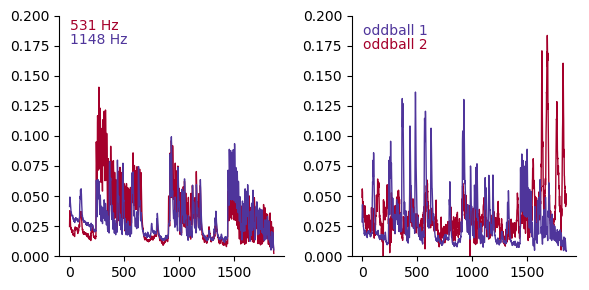

In [22]:
#figure(figsize=(10,10)); 
#rows,cols=4,3

figure(figsize=(6,3))
ax1 = subplot(121)
ax2 = subplot(122)

ctr = 1
cctr = 3
titles = ["531 Hz","1148 Hz"]
subplot(121)
for r in [5,6]
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    avg = vec(mean(DF[sr,:],dims=1))
    plot(avg,color=colors[cctr],linewidth=1)
    text(5,0.2.-(ctr*0.012),titles[ctr],color=colors[cctr])
    ctr+=1
    cctr+=1
end


ctr = 1
cctr = 3
titles = ["oddball 2","oddball 1"]
subplot(122)
for r in [8,7]
    #subplot(1,2,ctr)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    avg = vec(mean(DF[sr,:],dims=1))

    plot(avg,color=colors[cctr],linewidth=1)
    text(5,0.16.+(ctr*0.012),titles[ctr],color=colors[cctr])
    ctr+=1
    cctr+=1
end

ctr = 1
for ax in [ax1,ax2]
    ax.set_ylim(0,0.2)
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ctr+=1
end

tight_layout()

In [585]:
stim_freqs

5-element Vector{Float64}:
  531.0
 1189.0
  355.0
  794.0
 1778.0

In [25]:
figure(figsize=(6,5))

subplot(121); axis("off"); title("oddball")
scatter(centroids[sr1,2],centroids[sr1,1],c=reset_idx_fish[sr1]/n_fish,s=1,cmap=cm)

subplot(122); axis("off"); title("offset")
scatter(centroids[sr2,2],centroids[sr2,1],c=reset_idx_fish[sr2]/n_fish,s=1,cmap=cm)

LoadError: UndefVarError: cm not defined

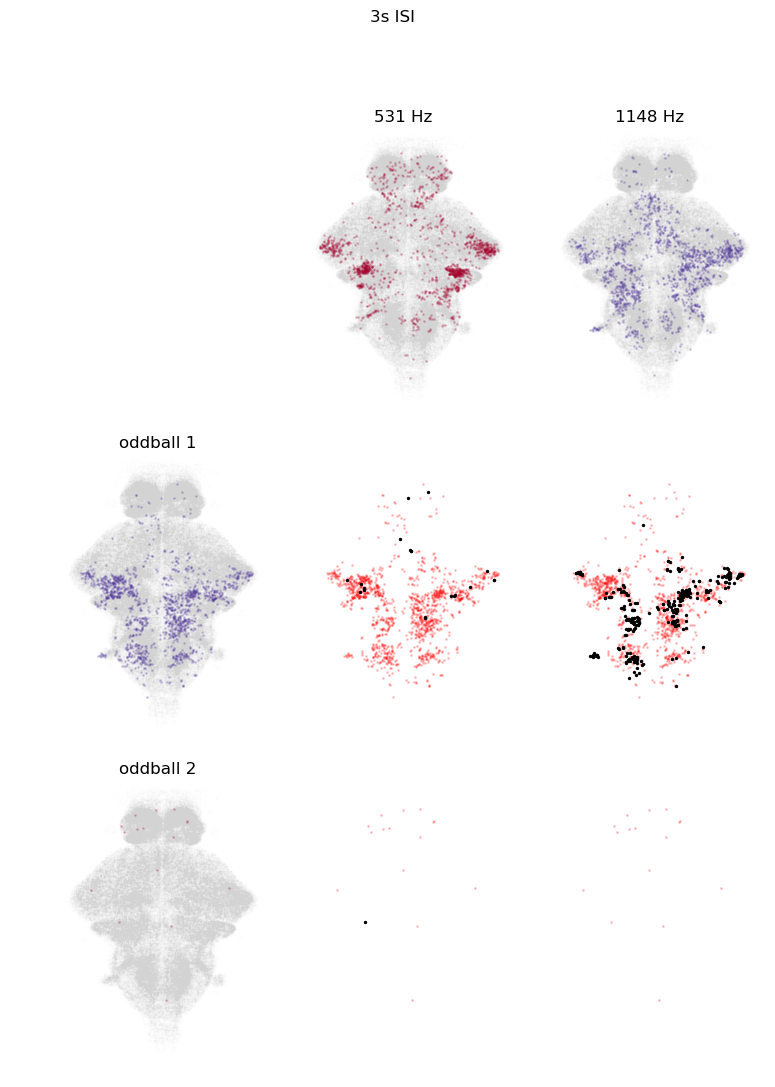

In [26]:
figure(figsize=(9,12)); 
suptitle("3s ISI")
a = 0.2

#titles = ["531 Hz","oddball 2","overlap"]

nr1 = nonsig_rois[6,:][1]; sr1 = sig_rois[6,:][1]
nr2 = nonsig_rois[7,:][1]; sr2 = sig_rois[7,:][1]

nr3 = nonsig_rois[5,:][1]; sr3 = sig_rois[5,:][1]
nr4 = nonsig_rois[8,:][1]; sr4 = sig_rois[8,:][1]
#or = intersect(sr2,sr3)

grid_size = 3

ax1 = subplot(3,3,1)
ax2 = subplot(3,3,2)
ax3 = subplot(3,3,3)
ax4 = subplot(3,3,4)
ax5 = subplot(3,3,5)
ax6 = subplot(3,3,6)
ax7 = subplot(3,3,7)
ax8 = subplot(3,3,8)
ax9 = subplot(3,3,9)


subplot(3,3,2); title("531 Hz")
scatter(centroids[nr3,2],centroids[nr3,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr3,2],centroids[sr3,1],color=colors[3],s=1,alpha=a)

subplot(3,3,3); title("1148 Hz")
scatter(centroids[nr1,2],centroids[nr1,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr1,2],centroids[sr1,1],color=colors[4],s=1,alpha=a)

subplot(3,3,4); title("oddball 1")
scatter(centroids[nr2,2],centroids[nr2,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr2,2],centroids[sr2,1],color=colors[4],s=1,alpha=a)

subplot(3,3,7); title("oddball 2")
scatter(centroids[nr4,2],centroids[nr4,1],color="lightgray",s=1,alpha=nsa)
scatter(centroids[sr4,2],centroids[sr4,1],color=colors[3],s=1,alpha=a)

### 531 vs oddball 1
subplot(3,3,5)
idx = intersect(sr2,sr3)
scatter(centroids[sr2,2],centroids[sr2,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)


### 531 vs oddball 2
subplot(3,3,8)
idx = intersect(sr4,sr3)
scatter(centroids[sr4,2],centroids[sr4,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)


### 1148 vs oddball 1
subplot(3,3,6)
idx = intersect(sr2,sr1)
scatter(centroids[sr2,2],centroids[sr2,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)

### 1148 vs oddball 2
subplot(3,3,9)
idx = intersect(sr4,sr1)
scatter(centroids[sr4,2],centroids[sr4,1],color="red",s=1,alpha=a)
scatter(centroids[idx,2],centroids[idx,1],color="black",s=2,alpha=1)


ctr = 1
for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
    ax.set_ylim(ymn,ymx)
    ax.set_xlim(xmn,xmx)
    ax.axis("off")
    ctr+=1
end

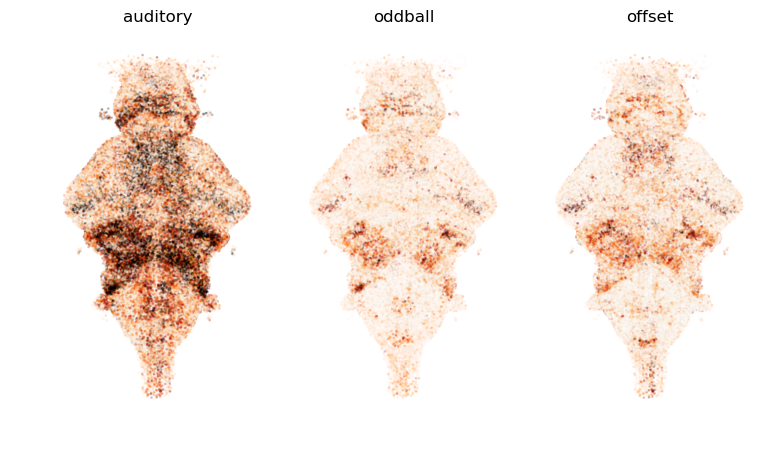

PyObject <matplotlib.collections.PathCollection object at 0x7f7ff7dbe860>

In [394]:
figure(figsize=(9,5)); 
a = 0.2
vm = 0.2

subplot(131); axis("off"); title("auditory")
scatter(centroids[:,2],centroids[:,1],c=r2s[1,:],cmap="gist_heat_r",s=1,alpha=a,vmin=0,vmax=vm)

subplot(132); axis("off"); title("oddball")
scatter(centroids[:,2],centroids[:,1],c=r2s[2,:],cmap="gist_heat_r",s=1,alpha=a,vmin=0,vmax=vm)

subplot(133); axis("off"); title("offset")
scatter(centroids[:,2],centroids[:,1],c=r2s[3,:],cmap="gist_heat_r",s=1,alpha=a,vmin=0,vmax=vm)

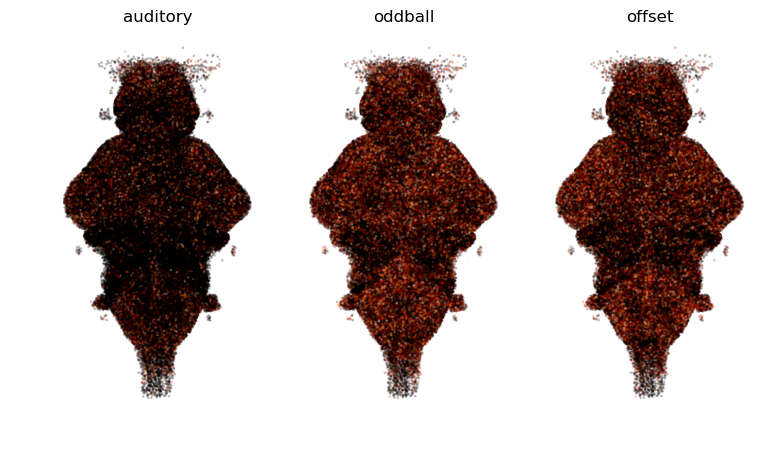

PyObject <matplotlib.collections.PathCollection object at 0x7f7ff9043b00>

In [410]:
figure(figsize=(9,5)); 

a = 0.2
vm = 1

cm = "gist_heat"

subplot(131); axis("off"); title("auditory")
scatter(centroids[:,2],centroids[:,1],c=pvals[1,:],cmap=cm,s=1,alpha=a,vmin=0,vmax=vm)

subplot(132); axis("off"); title("oddball")
scatter(centroids[:,2],centroids[:,1],c=pvals[2,:],cmap=cm,s=1,alpha=a,vmin=0,vmax=vm)

subplot(133); axis("off"); title("offset")
scatter(centroids[:,2],centroids[:,1],c=pvals[3,:],cmap=cm,s=1,alpha=a,vmin=0,vmax=vm)

In [510]:
idx_fish

1×186675 Matrix{Float64}:
 7.0  7.0  7.0  7.0  7.0  7.0  7.0  …  28.0  28.0  28.0  28.0  28.0  28.0

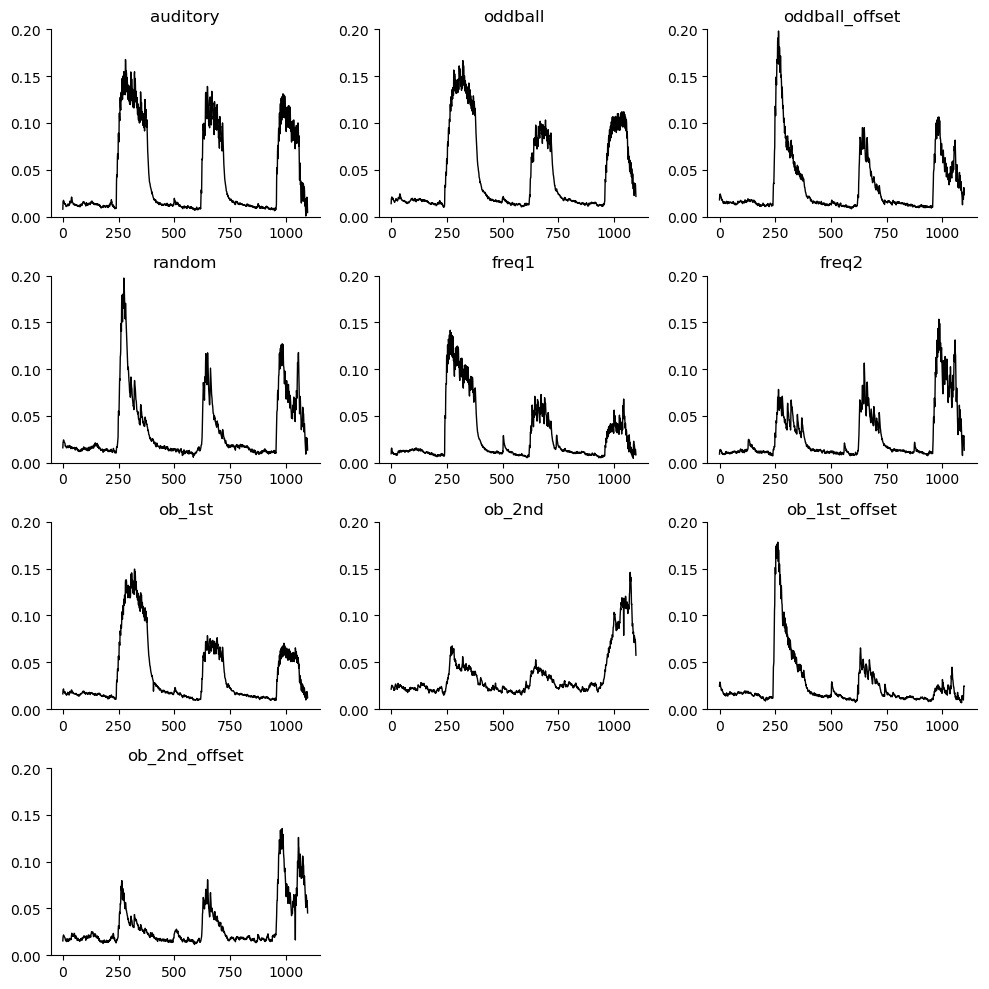

In [440]:
figure(figsize=(10,10)); 
rows,cols=4,3

r=1
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    ax = subplot(rows,cols,r); #axis("off")
    title(reg_titles[r])
    avg = vec(mean(DF[sr,:],dims=1))
    avg_n = vec(mean(filter(DF[nr,:]),dims=1))
    plot(avg_n,color="black",linewidth=1,alpha=0.5)
    plot(avg,color="black",linewidth=1)
    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
    ax.set_ylim(0,0.2)
end

tight_layout()

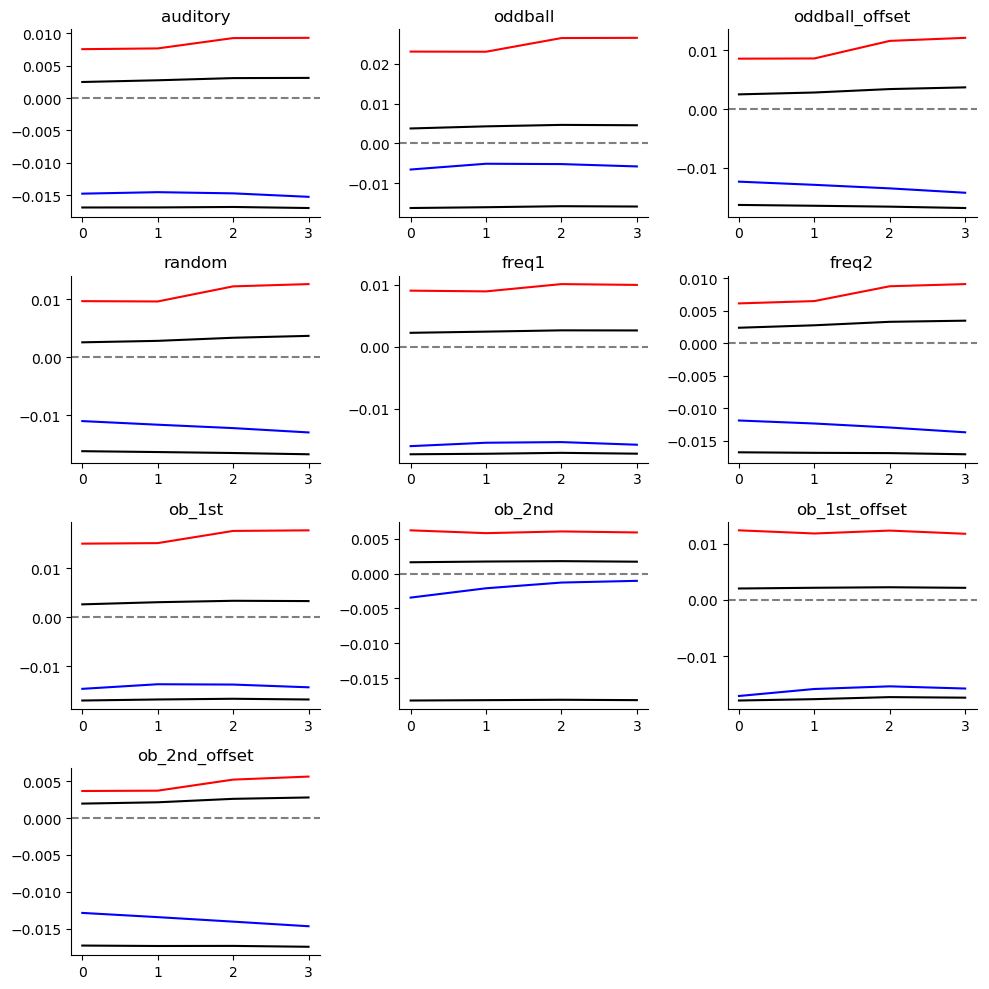

In [352]:
figure(figsize=(10,10)); 
rows,cols=4,3

r=1
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    ax =subplot(rows,cols,r); #axis("off")
    title(reg_titles[r])

    avg = zeros((4))
    addn = []
    for i in oddball_1st
        addn = vec(mean(DF[sr,i:i+3],dims=1))
        avg .+= addn
    end
    plot(avg./length(idx1),color="red")

    avg = zeros((4))
    addn = []

    for i in ms_f2_times
        addn = vec(mean(DF[sr,i:i+3],dims=1))
        avg .+= addn
    end
    plot(avg./length(idx2),color="black")

    avg = zeros((4))
    addn = []
    for i in oddball_2nd
        addn = vec(mean(DF[sr,i:i+3],dims=1))
        avg .+= addn
    end
    plot(avg./length(idx1).-0.02,color="blue")

    avg = zeros((4))
    for i in ms_f1_times
        addn = vec(mean(DF[sr,i:i+3],dims=1))
        avg .+= addn
    end
    plot(avg./length(idx2).-0.02,color="black")
    axhline(0,0,1,color="black",linestyle="dashed",alpha=0.5)
    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
end
tight_layout()

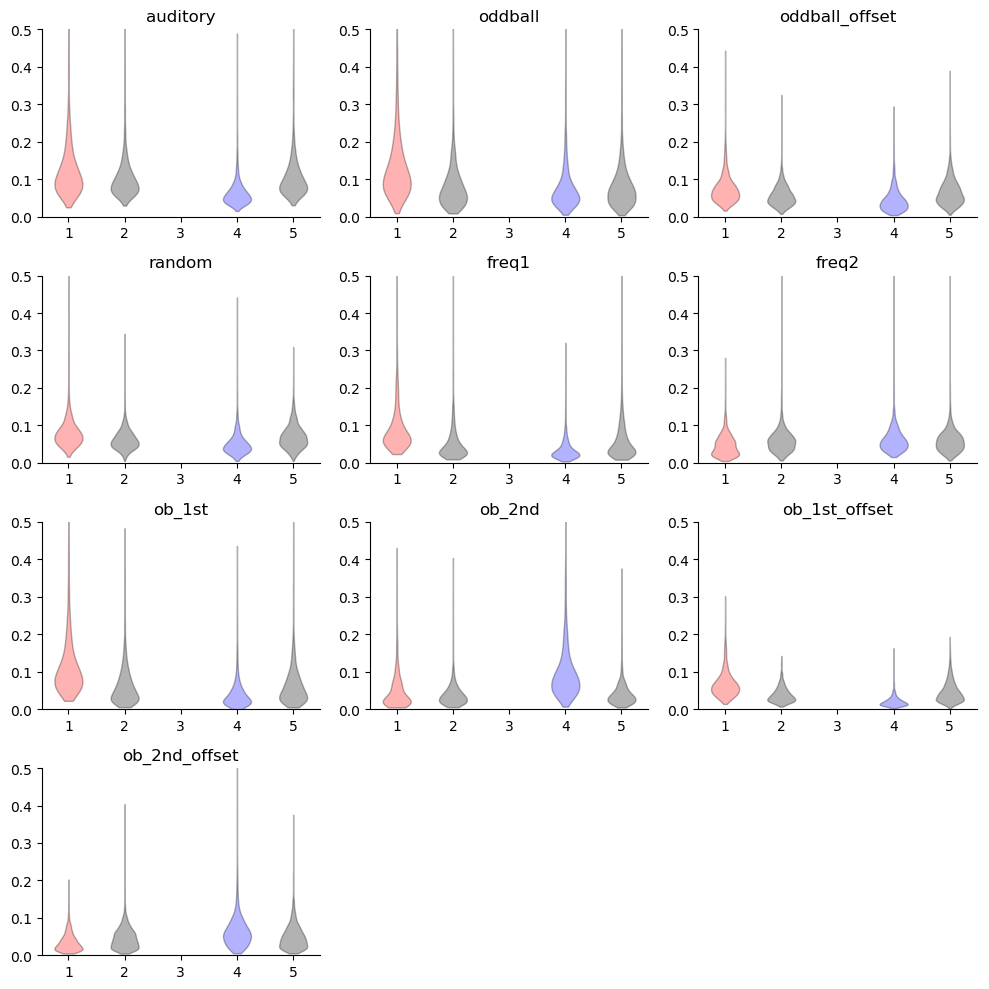

In [441]:
figure(figsize=(10,10)); 
rows,cols=4,3

function compute_mean_response(rois,stim_times)
    means = zeros(length(rois))
    for i in stim_times
        ctr = 1
        for s in rois
            y = mean(DF[s,i:i+3]); means[ctr] += y; ctr+=1
        end
    end
    means = means ./ length(stim_times)
    return means
end

r=1
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    ax = subplot(rows,cols,r); #axis("off")
    title(reg_titles[r])

    means = compute_mean_response(sr,oddball_1st)
    violin_parts = plt.violinplot(means, positions=[1],showextrema=false)#,facecolor="black")
    for pc in violin_parts["bodies"]
        pc.set_facecolor("red"); pc.set_edgecolor("black")
    end
    
    means = compute_mean_response(sr,ms_f2_times)
    violin_parts = plt.violinplot(means, positions=[2],showextrema=false)#,facecolor="black")
    for pc in violin_parts["bodies"]
        pc.set_facecolor("black"); pc.set_edgecolor("black")
    end
    
    
    means = compute_mean_response(sr,oddball_2nd)
    violin_parts = plt.violinplot(means, positions=[4],showextrema=false)#,facecolor="black")
    for pc in violin_parts["bodies"]
        pc.set_facecolor("blue"); pc.set_edgecolor("black")
    end
    
    means = compute_mean_response(sr,ms_f1_times)
    violin_parts = plt.violinplot(means, positions=[5],showextrema=false)#,facecolor="black")
    for pc in violin_parts["bodies"]
        pc.set_facecolor("black"); pc.set_edgecolor("black")
    end
    
    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
    ax.set_xticks([1,2,4,5],["f2 ob","f2 ms","f1 ob","f1 ms"])
    ylim(0,0.5)
end
tight_layout()

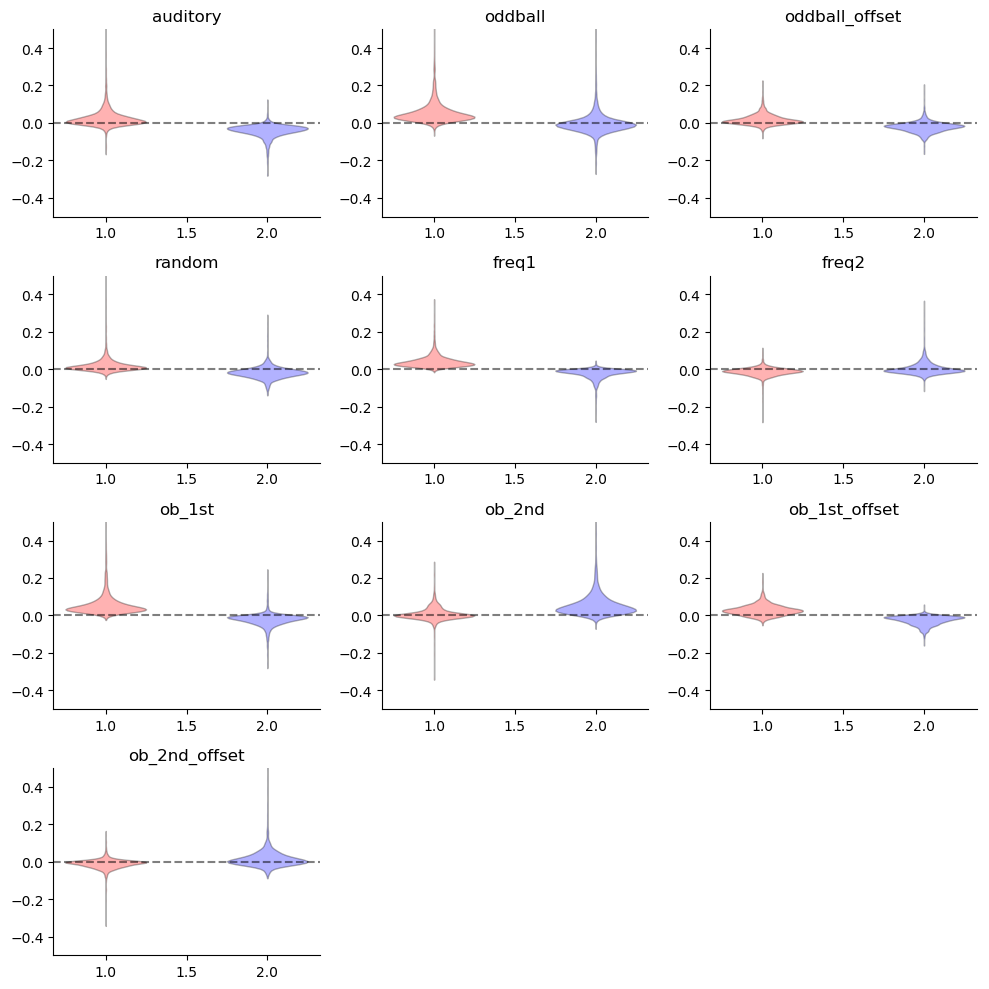

In [442]:
figure(figsize=(10,10)); 
rows,cols=4,3


function compute_mean_response(rois,stim_times)
    means = zeros(length(rois))
    for i in stim_times
        ctr = 1
        for s in rois
            y = mean(DF[s,i:i+3]); means[ctr] += y; ctr+=1
        end
    end
    means = means ./ length(stim_times)
    return means
end

r=1
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    ax = subplot(rows,cols,r); #axis("off")
    title(reg_titles[r])

    means = compute_mean_response(sr,oddball_1st)
    means_ms = compute_mean_response(sr,ms_f2_times)

    violin_parts = plt.violinplot(means.-means_ms, positions=[1],showextrema=false)#,facecolor="black")
    for pc in violin_parts["bodies"]
        pc.set_facecolor("red"); pc.set_edgecolor("black")
    end
    
    means = compute_mean_response(sr,oddball_2nd)
    means_ms = compute_mean_response(sr,ms_f1_times)

    violin_parts = plt.violinplot(means.-means_ms, positions=[2],showextrema=false)#,facecolor="black")
    for pc in violin_parts["bodies"]
        pc.set_facecolor("blue"); pc.set_edgecolor("black")
    end

    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
    axhline(0,0,1,linestyle="dashed",color="black",alpha=0.5)
    ylim(-0.5,0.5)
end
tight_layout()

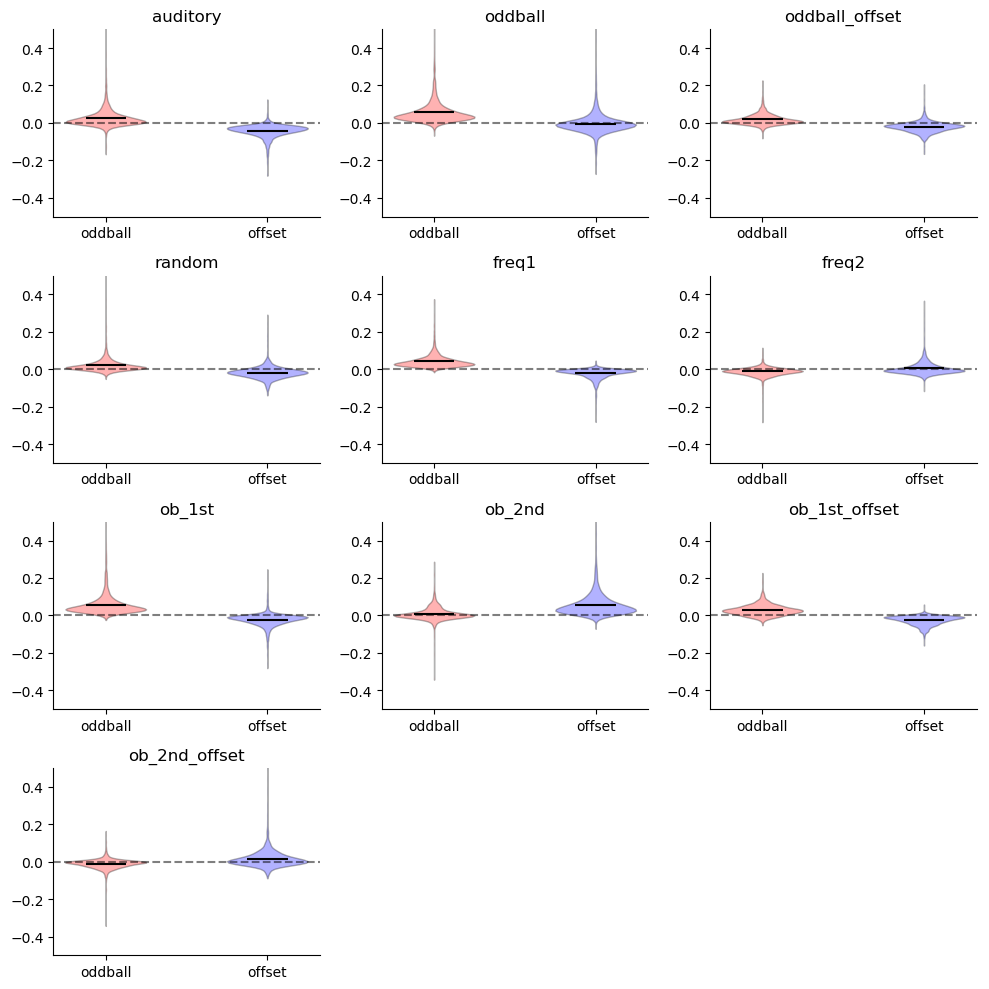

In [462]:
figure(figsize=(10,10)); 
rows,cols=4,3

r = 1
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    ax = subplot(rows,cols,r); #axis("off")
    title(reg_titles[r])

    means = compute_mean_response(sr,oddball_1st)
    means_ms = compute_mean_response(sr,ms_f2_times)

    violin_parts = plt.violinplot(means.-means_ms, positions=[1],showmeans=true,showextrema=false)#,showextrema=false)#,facecolor="black")
    for pc in violin_parts["bodies"]
        pc.set_facecolor("red"); pc.set_edgecolor("black")
    end
    violin_parts["cmeans"].set_color("black")    

    means = compute_mean_response(sr,oddball_2nd)
    means_ms = compute_mean_response(sr,ms_f1_times)

    violin_parts = plt.violinplot(means.-means_ms, positions=[2],showmeans=true,showextrema=false)#,facecolor="black")
    for pc in violin_parts["bodies"]
        pc.set_facecolor("blue"); pc.set_edgecolor("black")
        
        #'cbars','cmins','cmaxes','cmeans','cmedians'
    end
    violin_parts["cmeans"].set_color("black")    

#cbars','cmins','cmaxes','cmeans','cmedians'
    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
    axhline(0,0,1,linestyle="dashed",color="black",alpha=0.5)
    ylim(-0.5,0.5)
    ax.set_xticks([1,2])
    ax.set_xticklabels(["oddball","offset"])
end
tight_layout()

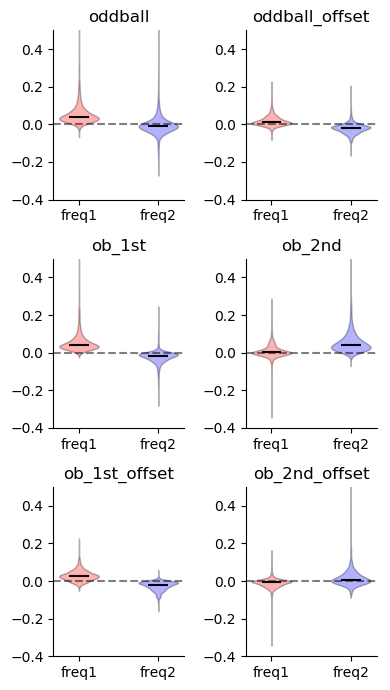

In [470]:
figure(figsize=(4,7)); 
rows,cols=3,2

r = 1
sp_ctr = 0
for r in [2,3,7,8,9,10]
    sp_ctr += 1
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    ax = subplot(rows,cols,sp_ctr); #axis("off")
    title(reg_titles[r])

    means = compute_mean_response(sr,oddball_1st)
    means_ms = compute_mean_response(sr,ms_f2_times)

    violin_parts = plt.violinplot(means.-means_ms, positions=[1],showmedians=true,showextrema=false)#,showextrema=false)#,facecolor="black")
    for pc in violin_parts["bodies"]
        pc.set_facecolor("red"); pc.set_edgecolor("black")
    end
    violin_parts["cmedians"].set_color("black")    

    means = compute_mean_response(sr,oddball_2nd)
    means_ms = compute_mean_response(sr,ms_f1_times)

    violin_parts = plt.violinplot(means.-means_ms, positions=[2],showmedians=true,showextrema=false)#,facecolor="black")
    for pc in violin_parts["bodies"]
        pc.set_facecolor("blue"); pc.set_edgecolor("black")
    end
    violin_parts["cmedians"].set_color("black")    

    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
    axhline(0,0,1,linestyle="dashed",color="black",alpha=0.5)
    ylim(-0.4,0.5)
    ax.set_xticks([1,2])
    ax.set_xticklabels(["freq1","freq2"])
end
tight_layout()

In [451]:
violin_parts

Dict{Any, Any} with 4 entries:
  "cbars"  => PyObject <matplotlib.collections.LineCollection object at 0x7f7ff…
  "bodies" => PyObject[PyObject <matplotlib.collections.PolyCollection object a…
  "cmins"  => PyObject <matplotlib.collections.LineCollection object at 0x7f7ff…
  "cmaxes" => PyObject <matplotlib.collections.LineCollection object at 0x7f7ff…

In [269]:
i =20
mean(DF[sr,i:i+3])

0.012314212984921883

In [250]:
addn

4-element Vector{Float64}:
 0.008713396212049845
 0.012815271044396562
 0.03751438699958518
 0.044864150871357235

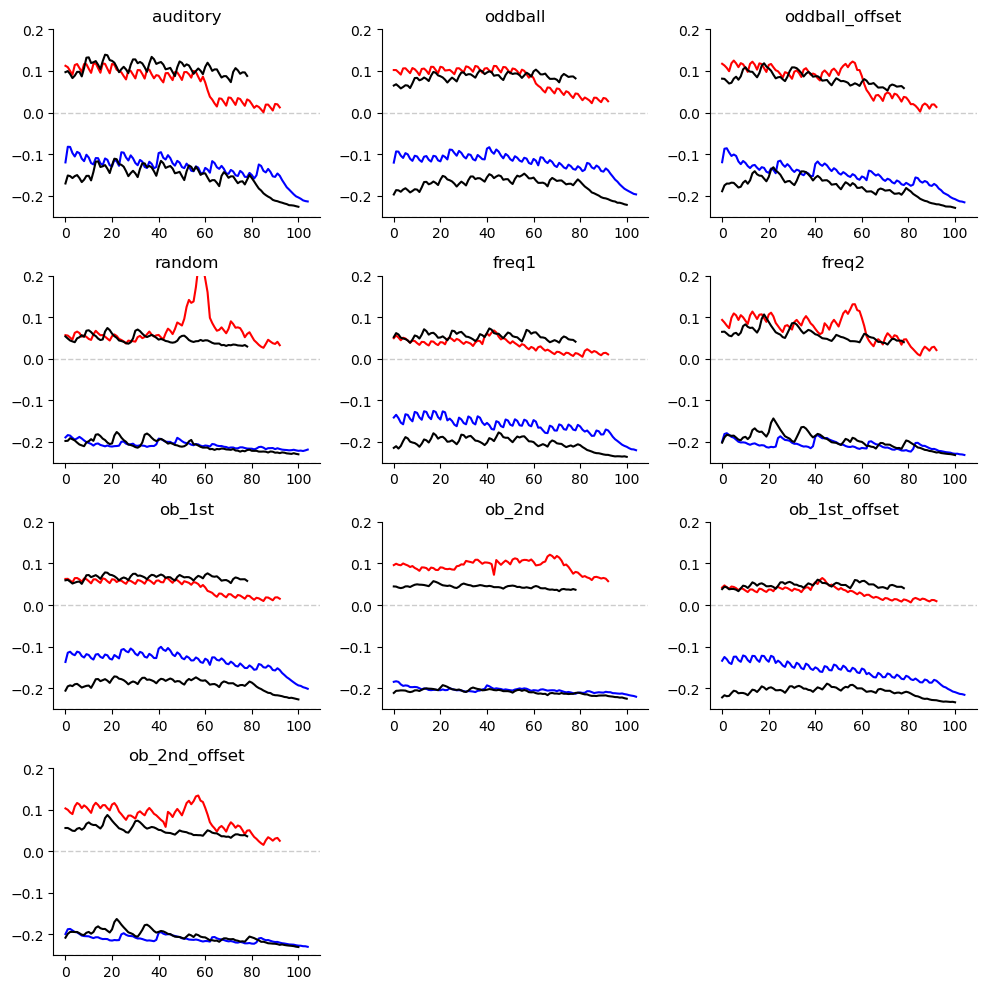

In [228]:
figure(figsize=(10,10)); 
rows,cols=4,3

r=1
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    ax =subplot(rows,cols,r); #axis("off")
    title(reg_titles[r])
    idx1 = findall(ob2_reg .> 0)
    idx2 = findall(ms_f1_reg .> 0)

    avg = vec(mean(DF[sr,idx1],dims=1))
    plot(avg,color="red")

    avg = vec(mean(DF[sr,idx2],dims=1))
    plot(avg,color="black")

    idx1 = findall(ob1_reg .> 0)
    idx2 = findall(ms_f2_reg .> 0)

    avg = vec(mean(DF[sr,idx1],dims=1))
    plot(avg.-0.25,color="blue")

    avg = vec(mean(DF[sr,idx2],dims=1))
    plot(avg.-0.25,color="black")

    axhline(-0.25,0,1,color="black",linestyle="dashed",linewidth=1,alpha=0.2)
    axhline(0,0,1,color="black",linestyle="dashed",linewidth=1,alpha=0.2)

    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
    ylim(-0.25,0.2)
end
tight_layout()

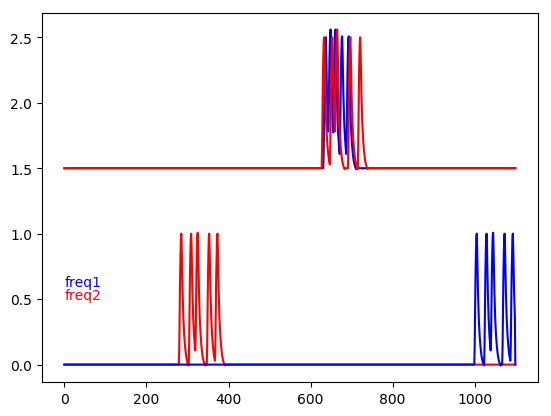

PyObject Text(0,0.5,'freq2')

In [232]:
plot(ob1_reg,color="red")
plot(ob2_reg,color="blue")
plot(ms_f1_reg.+1.5,color="blue")
plot(ms_f2_reg.+1.5,color="red")
text(0,0.6,"freq1",color="blue")
text(0,0.5,"freq2",color="red")

In [210]:
idx1 = findall(ob1_reg .> 0)

105-element Vector{Int64}:
 281
 282
 283
 284
 285
 286
 287
 288
 289
 290
 291
 292
 293
   ⋮
 380
 381
 382
 383
 384
 385
 386
 387
 388
 389
 390
 391

In [144]:
using Clustering

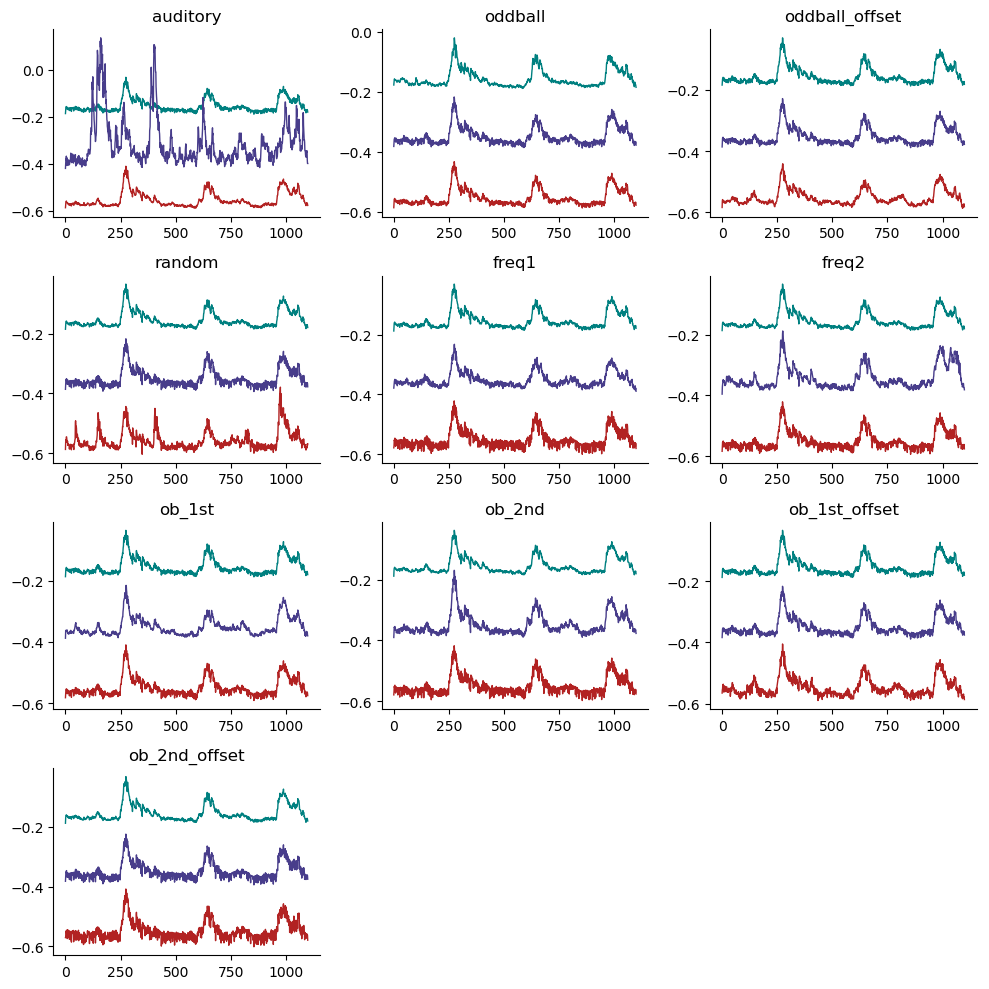

In [304]:
figure(figsize=(10,10)); 
rows,cols=4,3

colors = ["teal","darkslateblue","firebrick","olivedrab","mediumvioletred"]
n_clust = 3
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    
    km = kmeans(DF[sr,:]',n_clust)
    a = assignments(km)
    
    ax =subplot(rows,cols,r); #axis("off")
    title(reg_titles[r])
    for i = 1:n_clust
        idx = findall(a .== i)
        avg = vec(mean(DF[idx,:],dims=1))
        plot(avg.-i*0.2,linewidth=1,color=colors[i])
    end
    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
end
tight_layout()

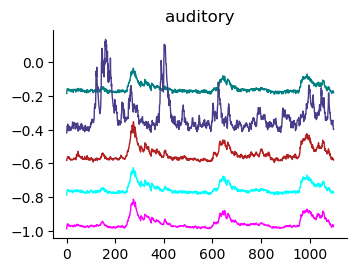

In [303]:
figure(figsize=(10,10)); 
rows,cols=4,3

colors = ["teal","darkslateblue","firebrick","cyan","magenta"]
n_clust = 5
r = 1
#for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    
    km = kmeans(DF[sr,:]',n_clust)
    a = assignments(km)
    
    ax =subplot(rows,cols,r); #axis("off")
    title(reg_titles[r])
    for i = 1:n_clust
        idx = findall(a .== i)
        avg = vec(mean(DF[idx,:],dims=1))
        plot(avg.-i*0.2,linewidth=1,color=colors[i])
    end
    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
#end
tight_layout()

In [160]:
counts(km)

3-element Vector{Int64}:
 910
   1
 189

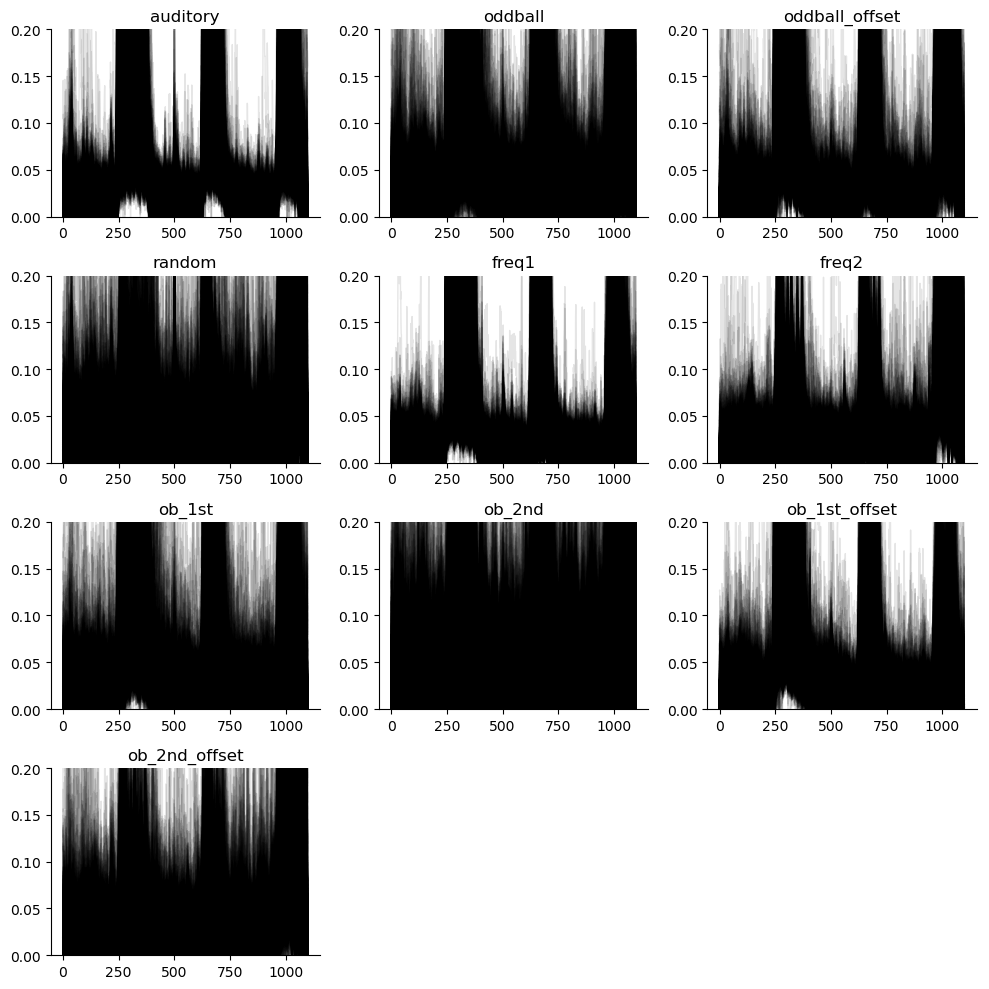

In [141]:
figure(figsize=(10,10)); 
rows,cols=4,3

r=1
for r=1:length(exp_regs)
    sr = sig_rois[r,:][1]
    nr = nonsig_rois[r,:][1]
    ax =subplot(rows,cols,r); #axis("off")
    title(reg_titles[r])
    avg = vec(mean(DF[sr,:],dims=1))
    for s in sr
        plot(DF[s,:],color="black",linewidth=1,alpha=0.1)
    end
    plot(avg,color="black",linewidth=1)
    ax.spines["top"].set_visible(false); ax.spines["right"].set_visible(false)
    ylim(0,0.2)
end

tight_layout()

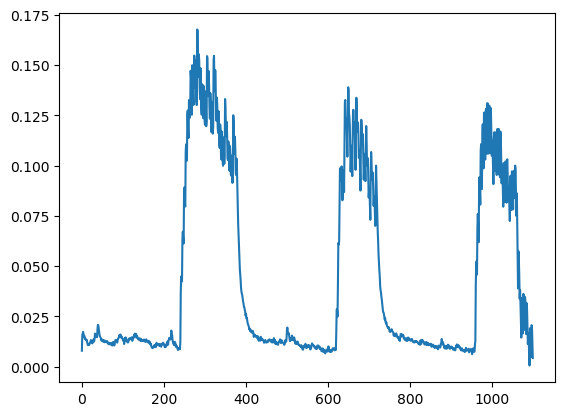

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f801cc22b70>

In [129]:
plot(vec(mean(DF[sr,:],dims=1)))

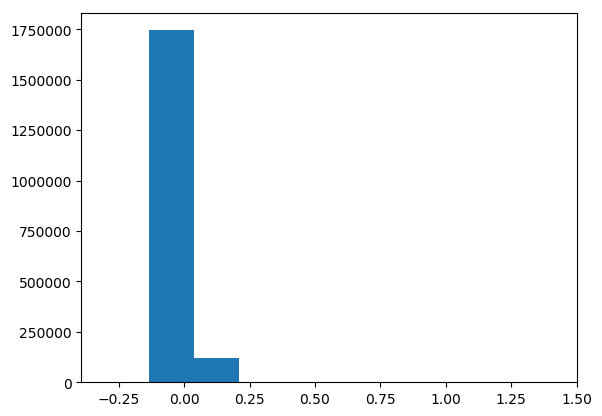

([77.0, 1.745321e6, 118936.0, 2018.0, 282.0, 80.0, 24.0, 10.0, 0.0, 2.0], Float32[-0.30705547, -0.13477132, 0.037512828, 0.20979698, 0.38208112, 0.5543653, 0.7266494, 0.8989336, 1.0712178, 1.2435019, 1.415786], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f801def1320>, PyObject <matplotlib.patches.Rectangle object at 0x7f801def1128>, PyObject <matplotlib.patches.Rectangle object at 0x7f801def1940>, PyObject <matplotlib.patches.Rectangle object at 0x7f801def1cc0>, PyObject <matplotlib.patches.Rectangle object at 0x7f801defa080>, PyObject <matplotlib.patches.Rectangle object at 0x7f801defa400>, PyObject <matplotlib.patches.Rectangle object at 0x7f801defa780>, PyObject <matplotlib.patches.Rectangle object at 0x7f801defab00>, PyObject <matplotlib.patches.Rectangle object at 0x7f801defae80>, PyObject <matplotlib.patches.Rectangle object at 0x7f801df04240>])

In [108]:
hist(vec(coeffs))

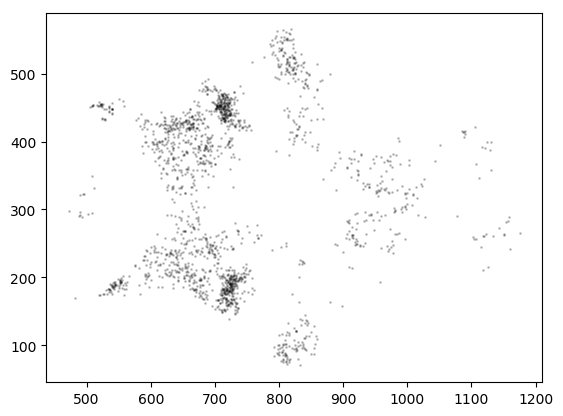

PyObject <matplotlib.collections.PathCollection object at 0x7f801f3f61d0>

In [20]:
scatter(centroids[sig_roi,1],centroids[sig_roi,2],color="black",alpha=0.2,s=1)#,bins=50)

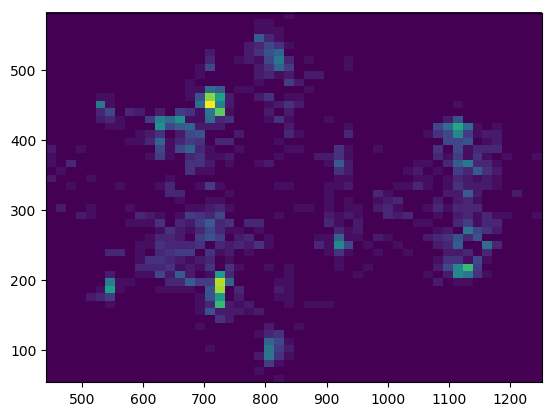

0

In [21]:
r2s_clean = replace(r2s[2,:],NaN=>0)#filter(isfinite,r2s[1,:])
sig_roi_o = findall(r2s_clean .> percentile(r2s_clean,perc_cutoff)); idx_rest = findall(r2s_clean .<= percentile(r2s_clean,perc_cutoff))
plt.hist2d(centroids[sig_roi_o,1],centroids[sig_roi_o,2],bins=50)
IJulia.clear_output()

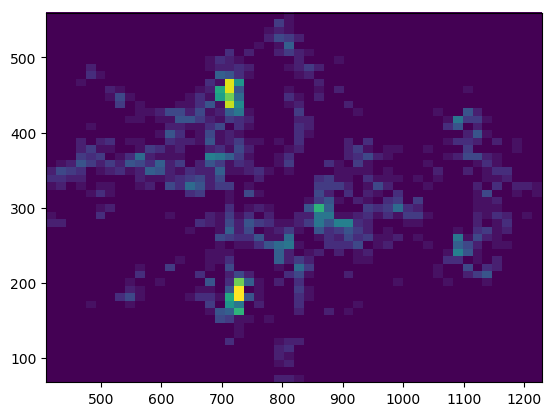

0

In [22]:
r2s_clean = replace(r2s[3,:],NaN=>0)#filter(isfinite,r2s[1,:])
sig_roi_or = findall(r2s_clean .> percentile(r2s_clean,perc_cutoff)); idx_rest = findall(r2s_clean .<= percentile(r2s_clean,perc_cutoff))
plt.hist2d(centroids[sig_roi_or,1],centroids[sig_roi_or,2],bins=50)
IJulia.clear_output()

In [23]:

#print(percentile(replace(r2s[2,:],NaN=>0),perc_cutoff));

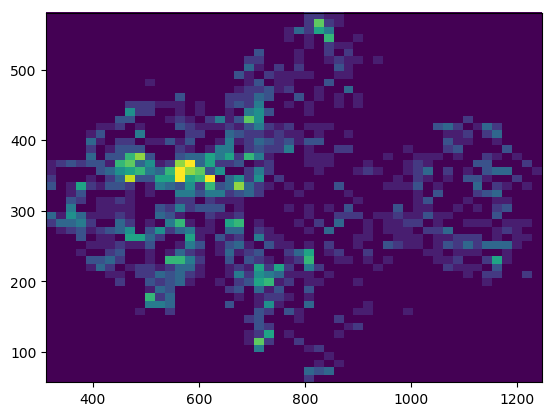

0

In [24]:
r2s_clean = replace(r2s[4,:],NaN=>0)#filter(isfinite,r2s[1,:])
sig_roi_r = findall(r2s_clean .> percentile(r2s_clean,perc_cutoff)); idx_rest = findall(r2s_clean .<= percentile(r2s_clean,perc_cutoff))
plt.hist2d(centroids[sig_roi_r,1],centroids[sig_roi_r,2],bins=50)
IJulia.clear_output()

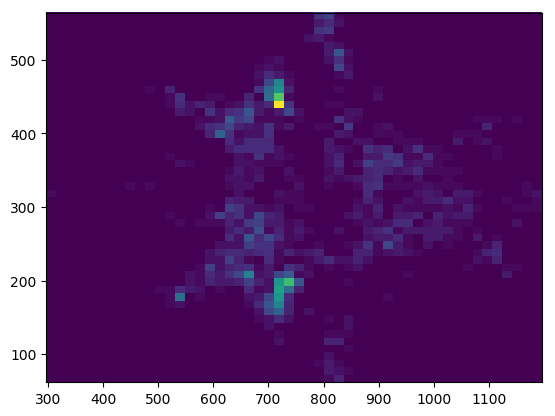

0

In [57]:
r2s_clean = replace(r2s[5,:],NaN=>0)#filter(isfinite,r2s[1,:])
f1_roi = findall(r2s_clean .> percentile(r2s_clean,perc_cutoff)); idx_rest = findall(r2s_clean .<= percentile(r2s_clean,perc_cutoff))
plt.hist2d(centroids[f1_roi,1],centroids[f1_roi,2],bins=50)
IJulia.clear_output()

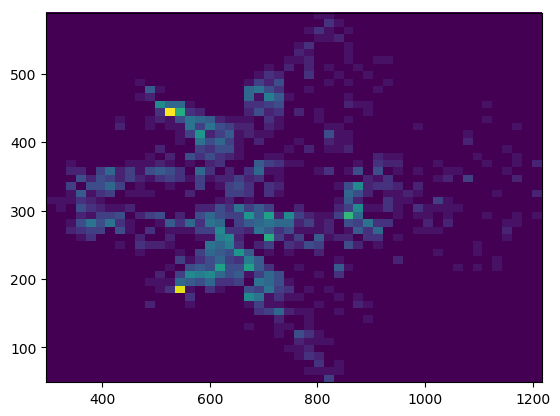

0

In [58]:
r2s_clean = replace(r2s[6,:],NaN=>0)#filter(isfinite,r2s[1,:])
f2_roi = findall(r2s_clean .> percentile(r2s_clean,perc_cutoff)); idx_rest = findall(r2s_clean .<= percentile(r2s_clean,perc_cutoff))
plt.hist2d(centroids[f2_roi,1],centroids[f2_roi,2],bins=50)
IJulia.clear_output()

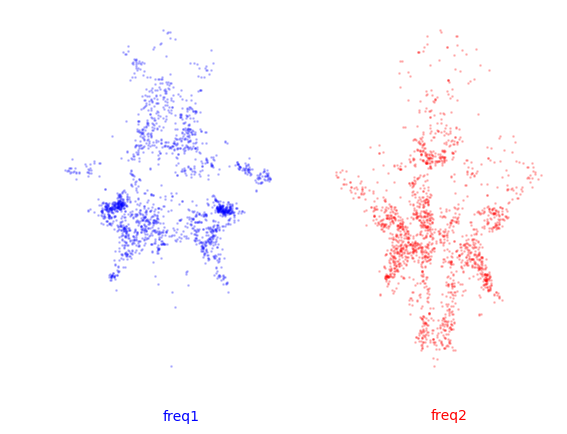

PyObject Text(300,150,'freq2')

In [67]:
subplot(121); axis("off")
scatter(centroids[f1_roi,2],centroids[f1_roi,1],color="blue",alpha=0.2,s=1)
text(300,150,"freq1",color="blue")

subplot(122);axis("off")
scatter(centroids[f2_roi,2],centroids[f2_roi,1],color="red",alpha=0.2,s=1)
text(300,150,"freq2",color="red")

In [69]:
for r = 1:6
    print(percentile(replace(r2s[r,:],NaN=>0),perc_cutoff));
    print("\n")
end

0.6413923549652104
0.14790072888135927
0.22842676460742956
0.09954852342605637
0.6085643458366394
0.4006619101762785


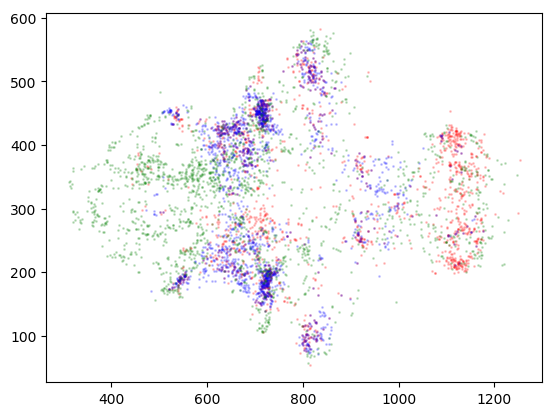

PyObject <matplotlib.collections.PathCollection object at 0x7f801f39a320>

In [28]:
scatter(centroids[sig_roi_o,1],centroids[sig_roi_o,2],color="red",alpha=0.2,s=1)#,bins=50)
scatter(centroids[sig_roi,1],centroids[sig_roi,2],color="blue",alpha=0.2,s=1)#,bins=50)
scatter(centroids[sig_roi_r,1],centroids[sig_roi_r,2],color="green",alpha=0.2,s=1)

In [29]:
oddball_only = []
for roi in sig_roi_o
    if roi in sig_roi
        continue
    else
        append!(oddball_only,roi)
    end
end

offset_only = []
for roi in sig_roi_or
    if roi in sig_roi
        continue
    else
        append!(offset_only,roi)
    end
end

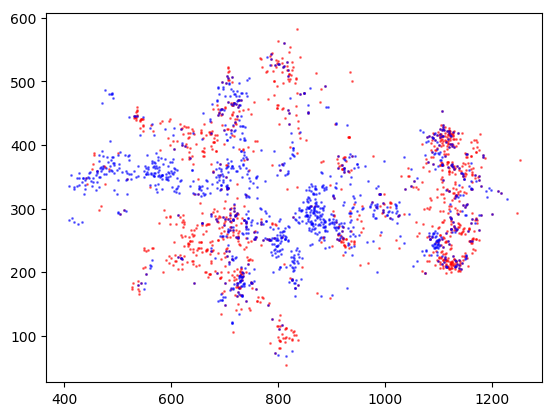

PyObject <matplotlib.collections.PathCollection object at 0x7f801e8b8c18>

In [71]:
scatter(centroids[oddball_only,1],centroids[oddball_only,2],color="red",alpha=0.5,s=1)#,bins=50)
scatter(centroids[offset_only,1],centroids[offset_only,2],color="blue",alpha=0.5,s=1)

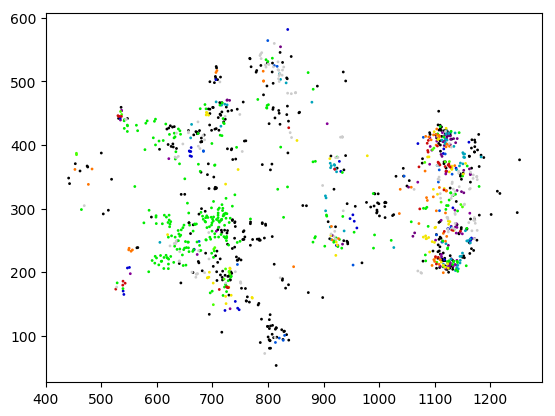

PyObject <matplotlib.collections.PathCollection object at 0x7f801f1c44e0>

In [31]:
#idx_fish
scatter(centroids[oddball_only,1],centroids[oddball_only,2],c=idx_fish[oddball_only]/100,s=1,cmap="spectral")#,bins=50)

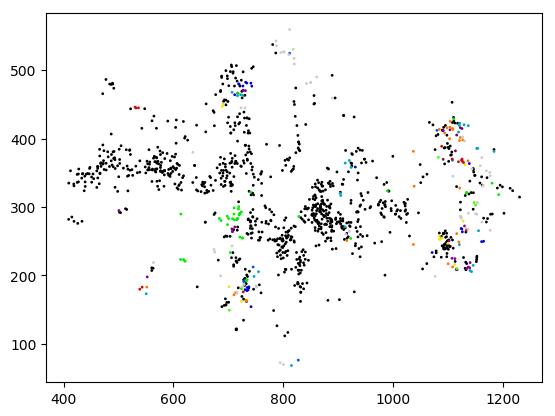

PyObject <matplotlib.collections.PathCollection object at 0x7f801f128c18>

In [32]:
scatter(centroids[offset_only,1],centroids[offset_only,2],c=idx_fish[offset_only]/100,s=1,cmap="spectral")#,bins=50)


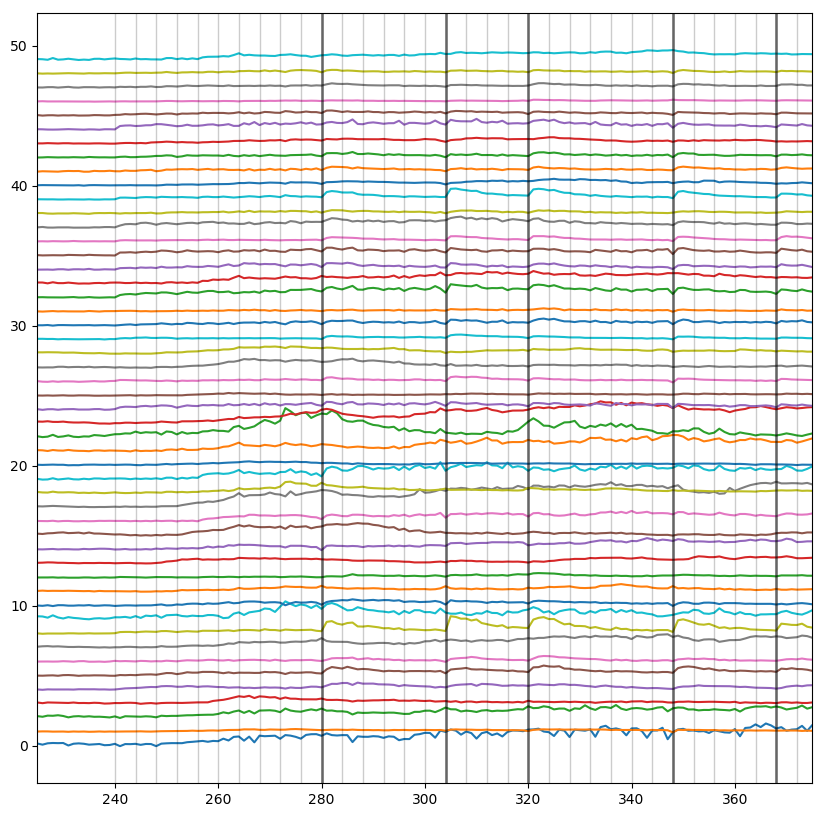

(225, 375)

In [57]:
figure(figsize=(10,10))

ctr = 0
for roi in sig_roi_o[1:50]
    plot(DF[roi,:].*2 .+ctr)
    ctr+=1
end

#x=collect(1:1100)
for stim in stimtimes
    axvline(stim,0,1,color="black",alpha=0.2,linewidth=1)
end

for oddball in oddball_times
    axvline(oddball,0,1,color="black",alpha=0.5,linewidth=2)
end

xlim(225,375)
#scatter(oddball_times,zeros(length(oddball_times)))

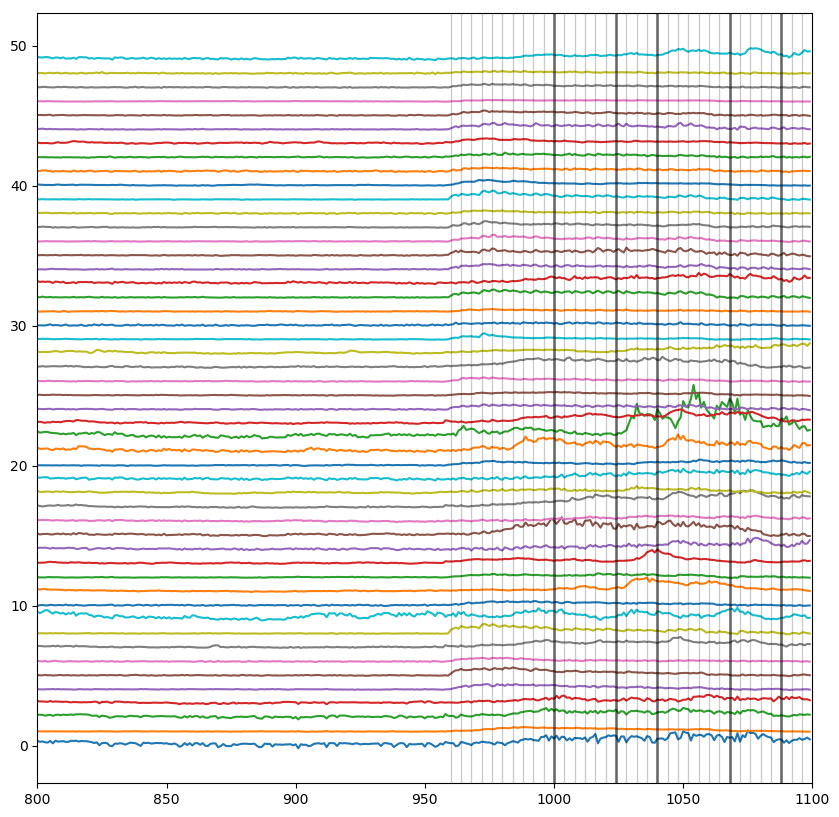

(800, 1100)

In [58]:
figure(figsize=(10,10))

ctr = 0
for roi in sig_roi_o[1:50]
    plot(DF[roi,:].*2 .+ctr)
    ctr+=1
end

#x=collect(1:1100)
for stim in stimtimes
    axvline(stim,0,1,color="black",alpha=0.2,linewidth=1)
end

for oddball in oddball_times
    axvline(oddball,0,1,color="black",alpha=0.5,linewidth=2)
end

xlim(800,1100)

In [64]:
#for i =1:total_rois
exp_regs = [auditory_reg,oddball_reg]
coeffs = Array{Float32}(undef,length(exp_regs),total_rois); fill!(coeffs,NaN)
r2s = Array{Float32}(undef,length(exp_regs),total_rois); fill!(r2s,NaN)
t = now()
print("starting $t ...")
for i = 1:total_rois
    reg_ctr = 1
    yr = DF[i,:]
    xr = auditory_reg
    df = DataFrame([yr,xr],["y","x"])
    ols = lm(@formula(y ~ x),df)
    if r2(ols) > 1
        continue
    end
    r2s[reg_ctr,i] = r2(ols)
    coeffs[reg_ctr,i] = coef(ols)[2]
    reg_ctr +=1
end
t = now()
print("complete $t")

starting 2024-02-15T15:42:12.948 ...complete 2024-02-15T15:42:28.626

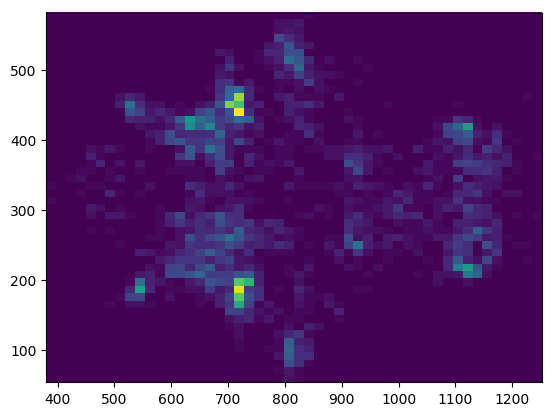

0

In [71]:
perc_cutoff = 98
r2s_clean = replace(r2s[1,:],NaN=>0)#filter(isfinite,r2s[1,:])
sig_roi = findall(r2s_clean .> percentile(r2s_clean,perc_cutoff)); idx_rest = findall(r2s_clean .<= percentile(r2s_clean,perc_cutoff))
plt.hist2d(centroids[sig_roi,1],centroids[sig_roi,2],bins=50)
IJulia.clear_output()

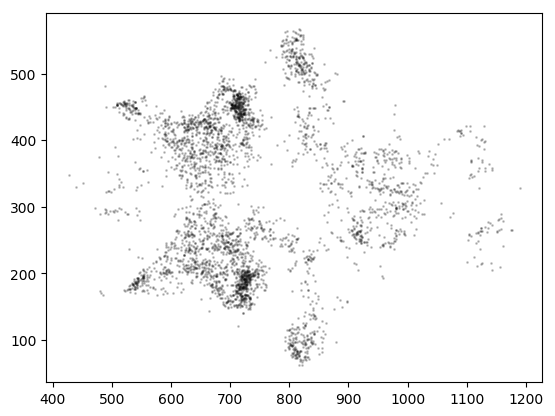

PyObject <matplotlib.collections.PathCollection object at 0x7fa3d7029710>

In [66]:
scatter(centroids[sig_roi,1],centroids[sig_roi,2],color="black",alpha=0.2,s=1)#,bins=50)

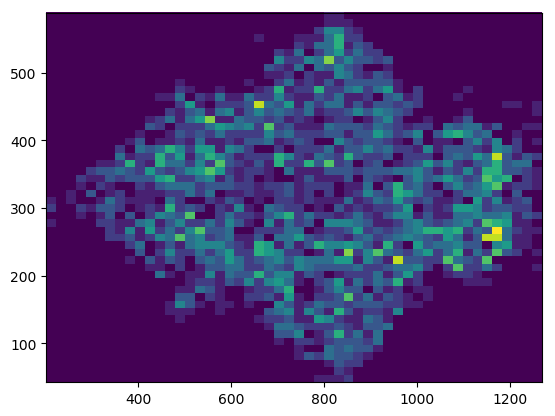

0

In [44]:
perc_cutoff = 95
r2s_clean = replace(r2s[2,:],NaN=>missing)#filter(isfinite,r2s[1,:])
sig_roi = findall(r2s_clean .> percentile(r2s_clean,perc_cutoff)); idx_rest = findall(r2s_clean .<= percentile(r2s_clean,perc_cutoff))
plt.hist2d(centroids[sig_roi,1],centroids[sig_roi,2],bins=50)
IJulia.clear_output()

In [45]:
sig_roi = findall(r2s_clean .> percentile(r2s_clean,perc_cutoff));

In [46]:
plt.scatter(centroids[:,1],centroids[:,2],bins=50)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/stednitz/.julia/packages/PyCall/L0fLP/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'AttributeError'>
AttributeError('Unknown property bins',)
  File "/usr/lib/python3/dist-packages/matplotlib/pyplot.py", line 3378, in scatter
    edgecolors=edgecolors, data=data, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/__init__.py", line 1718, in inner
    return func(ax, *args, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py", line 4032, in scatter
    collection.update(kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/artist.py", line 902, in update
    for k, v in props.items()]
  File "/usr/lib/python3/dist-packages/matplotlib/artist.py", line 902, in <listcomp>
    for k, v in props.items()]
  File "/usr/lib/python3/dist-packages/matplotlib/artist.py", line 895, in _update_property
    raise AttributeError('Unknown property %s' % k)


In [47]:
maximum(r2s_clean)

4.5037362f30

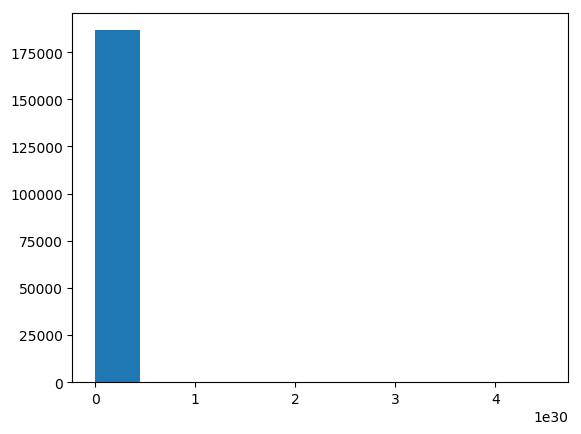

([186674.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], Float32[-1.1492887, 4.503736f29, 9.007472f29, 1.3511209f30, 1.8014944f30, 2.2518681f30, 2.7022418f30, 3.1526153f30, 3.6029888f30, 4.0533627f30, 4.5037362f30], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7fa3d96a9ba8>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3d96397b8>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3d96a96a0>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3d96a9898>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3d9681c18>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3d9681278>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3d96819b0>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3d96817b8>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3dc09b470>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3dc09bd30>])

In [48]:
hist(vec(r2s[2,:]))

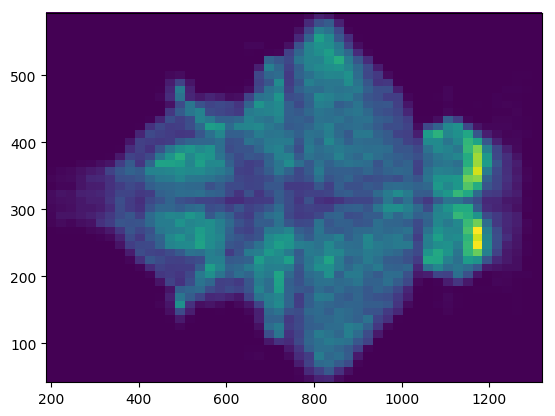

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [188.72000000000003, 211.36201800000003, 234.004036, 256.64605400000005, 279.288072, 301.93009, 324.572108, 347.21412599999996, 369.856144, 392.498162  …  1117.0427379999999, 1139.6847559999999, 1162.326774, 1184.968792, 1207.61081, 1230.252828, 1252.894846, 1275.536864, 1298.178882, 1320.8209], [42.0476, 53.082068, 64.116536, 75.151004, 86.185472, 97.21994, 108.254408, 119.28887599999999, 130.323344, 141.357812  …  494.4607879999999, 505.4952559999999, 516.529724, 527.5641919999999, 538.59866, 549.6331279999999, 560.6675959999999, 571.702064, 582.7365319999999, 593.771], PyObject <matplotlib.image.AxesImage object at 0x7fa3dc0705f8>)

In [23]:
plt.hist2d(centroids[:,1],centroids[:,2],bins=50)


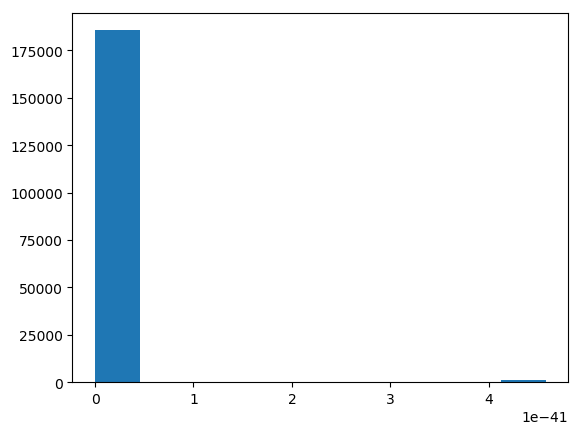

([185687.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 988.0], Float32[0.0, 4.58f-42, 9.157f-42, 1.3737f-41, 1.8316f-41, 2.2894f-41, 2.7474f-41, 3.2053f-41, 3.6633f-41, 4.1211f-41, 4.579f-41], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7fa3ec24cdd8>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3ec24ca58>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3f42af2b0>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3f42af470>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3f42afba8>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3ec22feb8>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3ec22f128>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3ec22fc50>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3ec22f4a8>, PyObject <matplotlib.patches.Rectangle object at 0x7fa3f4289828>])

In [21]:
hist(vec(r2s_clean))#[2,:])

In [22]:
percentile(r2s_clean,perc_cutoff)

0.0

In [60]:
length(sig_roi)

0

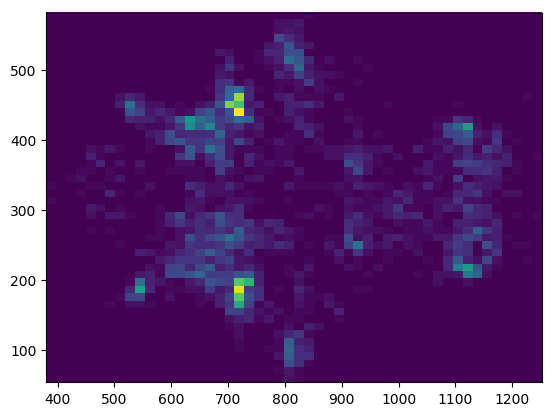

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [379.9100000000001, 397.35854000000006, 414.8070800000001, 432.2556200000001, 449.70416000000006, 467.1527000000001, 484.6012400000001, 502.04978000000006, 519.49832, 536.94686  …  1095.3001399999998, 1112.7486800000001, 1130.19722, 1147.6457599999999, 1165.0943, 1182.54284, 1199.99138, 1217.43992, 1234.8884600000001, 1252.337], [53.1851, 63.751177999999996, 74.317256, 84.88333399999999, 95.449412, 106.01549, 116.581568, 127.14764599999998, 137.71372399999998, 148.279802  …  486.39429799999994, 496.96037599999994, 507.52645399999994, 518.092532, 528.65861, 539.224688, 549.790766, 560.356844, 570.922922, 581.489], PyObject <matplotlib.image.AxesImage object at 0x7f7438985128>)

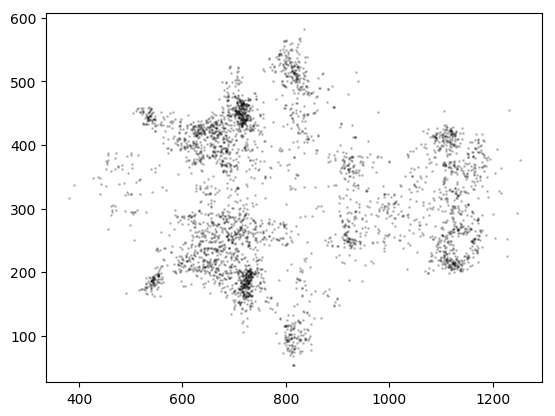

PyObject <matplotlib.collections.PathCollection object at 0x7f74389636d8>

In [57]:
scatter(centroids[sig_roi,1],centroids[sig_roi,2],color="black",alpha=0.2,s=1)#,bins=50)

In [154]:
size(centroids)

(186675, 3)

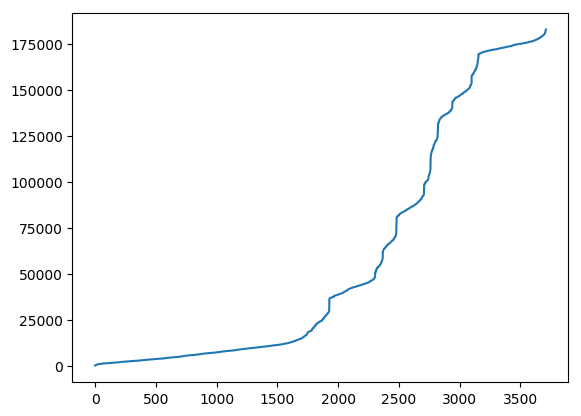

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f410d5f10f0>

In [155]:
plot(sig_roi)

In [81]:
#for roi in sig_roi
#    scatter(centroids[roi,1],centroids[roi,2],color="black",alpha=0.5, s=1)
#end

LoadError: InterruptException:

In [64]:
length(r2s)

186675

In [9]:
    coeffs = Array{Float32}(undef,length(exp_reg_titles),total_rois)
    r2s = Array{Float32}(undef,length(exp_reg_titles),total_rois)
    reg_ctr = 0
    for regressor in exp_regs
        reg_ctr +=1
        title = exp_reg_titles[reg_ctr]
        print("regressing $title ... ")
        for i =1:total_rois
            yr = A_corr[:,i]
            xr = regressor
            good_idx = findall(isfinite.(yr) .== 1)
            try
                df = DataFrame([yr[good_idx],xr[good_idx]],["y","x"])
                ols = lm(@formula(y ~ x),df)
                r2s[reg_ctr,i] = r2(ols)
                coeffs[reg_ctr,i] = coef(ols)[2]
            catch
                r2s[reg_ctr,i] = NaN
                coeffs[reg_ctr,i] = NaN
            end
        end
    end
    
    print("Computing percentiles and saving state regressions...")
    for i = 1:length(exp_reg_titles)
        title = exp_reg_titles[i]; create_group(reg_f,title)
        reg_f[title]["r2"]=r2s[i,:]; reg_f[title]["coef"]=coeffs[i,:]
    end
    
    for i = 1:length(exp_reg_titles)
        title=exp_reg_titles[i]*"_perc"
        diff = r2s[i,:]
        idx_95 = findall(diff .> percentile(diff,perc_cutoff)); idx_rest = findall(diff .<= percentile(diff,perc_cutoff))
        reg_f[title] = idx_95
    end

LoadError: MethodError: no method matching getindex(::HDF5.Group)
[0mClosest candidates are:
[0m  getindex(::Union{HDF5.File, HDF5.Group}, [91m::HDF5.Reference[39m) at ~/.julia/packages/HDF5/t07BK/src/HDF5.jl:1027
[0m  getindex(::Union{HDF5.File, HDF5.Group}, [91m::AbstractString[39m; pv...) at ~/.julia/packages/HDF5/t07BK/src/HDF5.jl:519